In [1]:
from IPython.core.display import HTML
display(HTML("""
<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>"""))

**Import libraries and save global variables**

In [3]:
import nltk
from PIL import Image
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import requests
proxies = {'http': 'http://206.189.157.23'}
abspath_alltime = ("/mnt/processed/private/msds2023/lt2/Lab2/"
                   "Movie_Info_All_Time_Lists.pkl")
abspath_countdown = ("/mnt/processed/private/msds2023/lt2/Lab2/"
                     "Movie_Info_Countdown_Lists.pkl")
abspath_casts_and_crew = ("/mnt/processed/private/msds2023/lt2/Lab2/"
                          "Cast_and_Crew.pkl")
abspath_combined = "/mnt/processed/private/msds2023/lt2/Lab2/Combined.pkl"
%matplotlib inline

c_red = '#fa320a'
c_gray = '#717171'
c_yellow = '#fed600'
c_white = '#ffffff'
c_black = '#1c1c1c'
c_green = '#0ec752'
c_darkgreen = '#03902e'

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('mode.chained_assignment', None)

**Utility functions**

In [3]:
def scrape_lists(base, path):
    """Returns a data frame containing titles and links of articles
    published after 2015 based on a given base url and path."""
    url = urljoin(base, path)
    url_next = None
    soup = BeautifulSoup(requests.get(url, proxies=proxies).content)

    titles = [x.text for x in soup.select('.row .articleLink .title')]
    links = [x['href'] for x in soup.select('.row .articleLink')]
    years = [int(x.text[-4:]) for x in soup.select('.row .publication-date')]

    df1 = (pd.DataFrame({'title': titles, 'link': links, 'year': years}))

    # If there is next page, scrape and append to dataframe
    if bool(soup.select_one('.js-wpv-pagination-next-link')):
        next_path = soup.select_one('.js-wpv-pagination-next-link')['href']
        url_next = urljoin(base, next_path)
        df2 = scrape_lists(base, url_next)
        df1 = pd.concat([df1, df2], axis=0, ignore_index=True)
    return df1[df1['year'] > 2015]


def get_movies(url):
    """Returns a dictionary of all the movies and links inside a given url.
    """
    soup = BeautifulSoup(requests.get(url, proxies=proxies).content)
    return {x.text: x['href'] for x in soup.select('.countdown-item h2 a')}


def get_movie_info(movie_url):
    """Returns a dictionary of all the movie info of a given movie_url."""
    response = requests.get(movie_url, proxies=proxies)
    soup = BeautifulSoup(response.content)
    fields = {'Title': soup.select_one('h1.scoreboard__title').text,
              'Synopsis': soup.select_one('#movieSynopsis').text.strip(),
              'Casts_and_crew': (
                  ', '.join([name.get_text().strip()
                             for name in soup.select(
                                 "#movie-cast > div > div > div > div.media-body > a > span")]))}
    fields2 = [a.get_text().replace('\n', "").replace("  ", '').strip(
    ).split(':') for a in soup.select('li.meta-row')]
    fields2 = {x[0]: x[1] for x in fields2}
    fields.update(fields2)
    return fields


def df_links_to_dict(df):
    """Compiles the movie title and its link in a dictionary. """
    lst = df['movies'].to_frame().to_dict('split')['data']
    links_dict = dict()
    for row in lst:
        for j in row:
            for key, val in j.items():
                links_dict[key] = val
    return links_dict


def df_info(df):
    """Returns the dimensions, info, and statistics of a given data frame."""
    # Preview data
    display(df.head(1))

    # Get the dimensions of the df
    print(f'Number of rows: {df.shape[0]}\n'
          f'Number of columns: {df.shape[1]}\n')

    # List the datatype of each column and count of non-null values
    print(f'List of all columns, count of non-null values, and datatypes of '
          'the df:\n')
    display(df.info())

    # Get summary statistics for the numerical columns and transpose the DataFrame
    # for more readable output
    print(f'\nSummary statistics for numerical columns:\n')
    display(df.describe())

    # Get summary statistics for the object (string) columns
    print(f'Summary statistics for object(string) columns:\n')
    display(df.describe(include=[object]).T)

    # Get count of null values
    print(f'Check for null columns:\n')
    display(df.isna().sum())

    # display % of null values per column
    print(f'Display % of null columns:\n')
    display(df.isna().sum() / (len(df))*100)


def split_to_bow(docs, max_n=None, delim=', '):
    """Return DataFrame of list of documents' bag-of-words representation
    given the delimeter and maximum number of splits."""
    df = pd.DataFrame([Counter(x.lower().split(delim)[:max_n])
                      for x in docs]).fillna(0)
    return df.reindex(sorted(df.columns), axis=1)


def to_bow(x, col_name, min_df=0.001, max_df=0.800, ngram_range=(1, 3),
           token_pattern=r'(?u)\b(\w(?:\w|\-)+)\b'):
    """Return BOW of words given column"""
    # import nltk
    # from nltk.corpus import stopwords
    # nltk.download('stopwords')
    # print(stopwords.words('english'))
    tfidf_vectorizer = TfidfVectorizer(
        token_pattern=token_pattern,
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram_range,
        stop_words=stopwords
    )
    vec = tfidf_vectorizer.fit_transform(x[col_name].fillna(''))
    return {
        'data': vec.toarray(),
        'columns': tfidf_vectorizer.get_feature_names_out()
    }


stopwords = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
    "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
    'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
    'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
    'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did',
    'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as',
    'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above',
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when',
    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
    'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just',
    'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
    "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
    'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn',
    "wouldn't"
]


def top_casts():
    """Return a horizontal bar graph of the top 10 casts."""
    df_casts_and_crew = pd.read_pickle(abspath_casts_and_crew)
    mask = df_casts_and_crew.sum(axis=0).sort_values(ascending=False)[:10]
    mask = mask.sort_values(ascending=True)
    ax = mask.plot(kind='barh', figsize=(20, 10), color=c_red, alpha=0.8)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlabel('Count of movies', fontsize=24)
    ax.set_ylabel('Casts', fontsize=24)
    ax.set_title("These 10 men were the most frequently casted in our "
                 "movies list.",
                 fontsize=30, color=c_red)
    plt.tight_layout()


def clean_tokens(data):
    """Returns the individual words based on a given data."""
    # nltk.download('punkt')
    # nltk.download('wordnet')
    # nltk.download('omw-1.4')
    words = " ".join(data)
    tokens = word_tokenize(words)
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens


def create_word_cloud(data, title, collocations=False):
    """Creates a word cloud based on a give series, title, and 
    collocations (if bigrams are considered).
    """
    new_tokens = clean_tokens(data)
    bow = " ".join(new_tokens)
    mask = np.array(Image.open('Rotten_Tomatoes.png'))

    word_cloud = WordCloud(background_color='white',
                           mask=mask,
                           colormap='gist_heat',
                           max_words=300,
                           contour_color=c_red,
                           contour_width=5,
                           collocations=collocations,
                           font_step=2,
                           random_state=1).generate(bow)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(title, fontsize=25, color=c_red, loc='center')
    plt.imshow(word_cloud)
    plt.tight_layout()


def theater_movie_releases():
    """Returns count of yearly theater movie releases."""
    ax = df_combined_all['Release Date (Theaters)'].str.extract(
        r'(\d{4})').value_counts().sort_index()[:-1]
    ax.index = [int(x[0]) for x in ax.index]
    ax = ax.plot(figsize=(20, 10), color=c_red, lw=3)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlabel('Release Year (Theaters)', fontsize=24)
    ax.set_ylabel('Number of movies', fontsize=24)
    title = """The Rotten Tomatoes lists showcases
    a wide variety of movies from all years"""
    ax.set_title(title, fontsize=30, color=c_red)
    ax.grid(axis='y')
    plt.xlim(1980, 2023)
    ax.text(2000, 210, 'Increasing Overall Trend', fontsize=20)
    ax.text(2020, 160, 'COVID-19\nPandemic', fontsize=20, ha='center')
    plt.tight_layout()


def streaming_movie_releases():
    """Returns count of yearly streaming movie releases."""
    ax = df_combined_all['Release Date (Streaming)'].str.extract(
        r'(\d{4})').value_counts().sort_index()
    ax.index = [int(x[0]) for x in ax.index]
    ax = ax.plot(figsize=(20, 10), color=c_red, lw=3)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlabel('Release Year (Streaming)', fontsize=24)
    ax.set_ylabel('Number of movies', fontsize=24)
    ax.axvspan(2001, 2009, color=c_yellow, alpha=0.3)
    ax.axvspan(2015, 2021, color=c_yellow, alpha=0.3)
    ax.plot(2007, 429, color='black', ls='-', marker='.', ms=20)
    ax.plot(2016, 344, color='black', ls='-', marker='.', ms=20)
    plt.xlim(1990, 2023)
    ax.grid(axis='y')
    title = """Movies in the Rotten Tomatoes lists are mostly released for 
    streaming during the mid 2000s and late 2010s."""
    ax.set_title(title, fontsize=30, color=c_red)
    text = """On Jan. 6, 2016,
    Netflix went live in
    130 countries simultaneously."""
    ax.text(2016, 330, text, fontsize=15, va='top')
    text = "In 2007, Netflix began streaming."
    ax.text(2007, 450, text, fontsize=15)
    plt.tight_layout()


def top_language():
    """Returns the language proportion of English and others."""
    title = """Majority of movies are in English"""

    ax = (df_combined_all['Original Language'] == 'English').value_counts()
    ax = ax.plot(
        kind='pie',
        figsize=(20, 10),
        autopct='%1.0f%%',
        fontsize=40,
        labels=None,
        colors=['#fc6444', c_gray])
    ax.legend(['English (US)', 'Others'], loc='lower left', fontsize=17)
    ax.set_title(title, fontsize=30, color=c_red)
    ax.tick_params(axis='x', labelsize=20)
    plt.tight_layout()


def top_non_english():
    """Returns the top 10 non-English movie languages."""
    ax = df_combined_all['Original Language'].value_counts()[:0:-1].tail(10)
    ax = ax.plot(kind='barh', figsize=(20, 10), color=c_red, alpha=0.8)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlabel('Count', fontsize=24)
    ax.set_ylabel('Language', fontsize=24)
    ax.set_title("Top 10 Non-English (US) Languages", fontsize=30, color=c_red)
    plt.tight_layout()

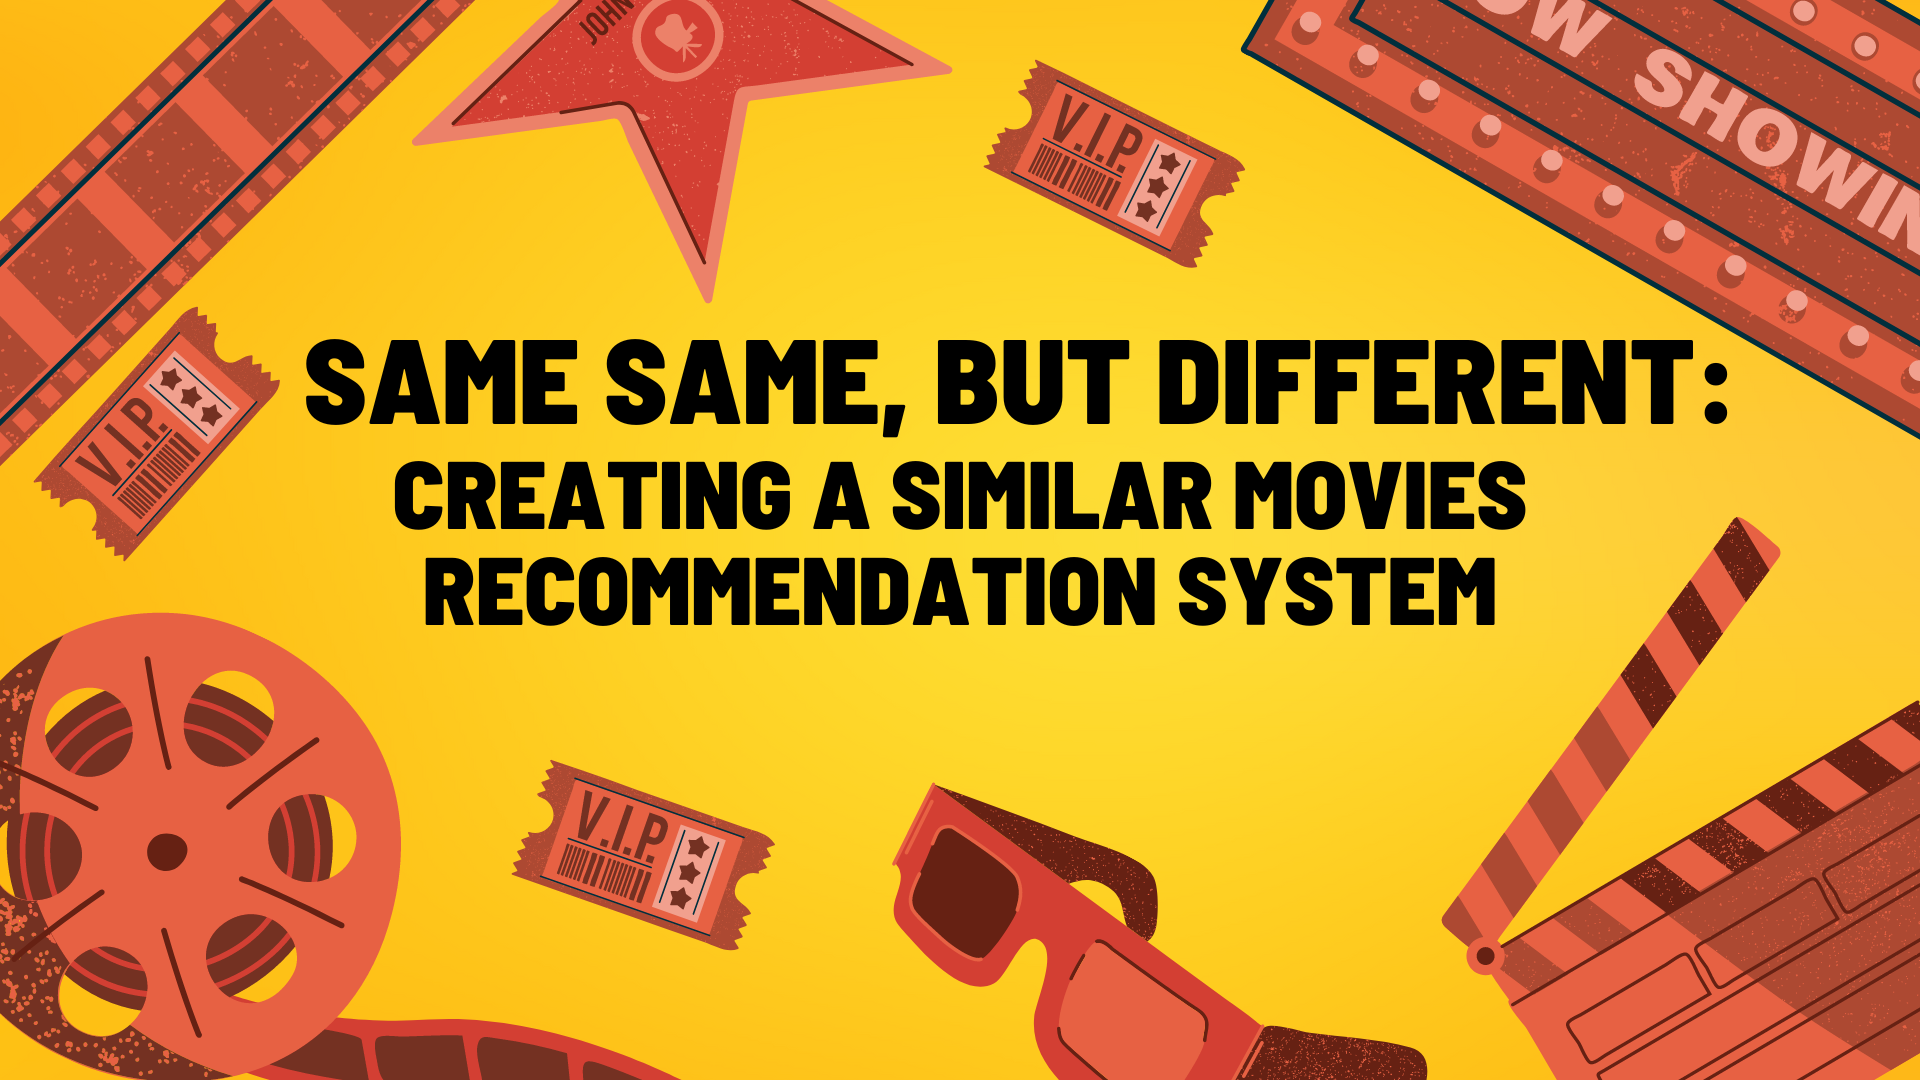

<h1 style="color:#0ec752">EXECUTIVE SUMMARY</h1>

In general, movie recommendation systems (MRS) are created to provide the most relevant movie to a user based on the latter's preferences and inputs. By creating an MRS, together with a large database of movie information, we were able to answer the following problem statement:

_"Which among Rotten Tomatoes' movies are similar to a given movie in terms of movie plot and casts?"_

To aid our analysis, the team applied a methodology involving data scraping, data cleaning and processing, exploratory data analysis to explore and gather insights from our data, and utilize information retrieval models such as Bag-Of-Words representation to perform feature extraction and Term Frequency - Inverse Document Frequency (TF-IDF) as a scoring measure to help identify the most similar movies based on a given movie title/index.

Considering the ease of access and abundance of movie choices available for immediate consumption of each user, we worked on adding value to the users by providing them with an MRS that could immediately provide the most similar movies from a movie that they input in our model. This reduces the time that a user spends on browsing through several movies instead of immediately watching a movie that is most similar to their taste. 

In terms of the existing movie database collected from this study, we noted that drama, comedy, mystery, and thriller led the movie genre category. The database lacks documentary genre yet, so this should be addressed by future works to increase user choices and improve user satisfaction. In line with the most popular genres, the most common words in title pertain to man, night, day, love, and last which are consistent with the common practice of setting movie titles that are simple, easy to understand, provides some context or characters about the plot, and interesting. Likewise, top plot themes pertain to life, new, and find. Lastly, the most popular casts or mostly casted actors are all men and unlike the other categories, such actors have been into diverse types of movies, instead of just drama.

One challenge that we have faced in this study was that even if we know that including and combining more features from the movie info scraped could provide higher relevance in terms of getting the most similar movie, due to memory constraints and incomplete data obtained for those features, we decided to drop those ideas and leave it for future work.

Despite the aforementioned limitation, the Bag-of-words and TF-IDF with cosine similarity distance metric have been extremely instrumental in building our model which provided accurate results when tested.

After completing the basic MRS and considering our limited resources and constraints, we were able to arrive at the following recommendations: include more movies from different sources, preferably via API for smoother and faster processing; increase the number of cast members used during information retrieval step of this study; use more detailed synopses to enhance the bag of words data and consequently improve relevance of synopsis-based recommendations; expand search categories to allow searches by casts, plot themes, and others; turn this project into a business and move from item-based filtering to user-based collaborative filtering; and finally, once the previous recommendations are stable, expand the coverage of this MRS to include TV series, movie and tv series reviews, blogs, songs, and others to increase website traffic, engagement, and consequently, revenues.

**This study is highly relevant, timely, and has potential business value** since recommender systems that enhance user experience and provide the most personalized and value-adding results could mean more loyal site visits and engagement from user. Consequently, higher engagement means higher potential advertising and other revenues.

<h1 style="color:#0ec752">PROBLEM STATEMENT</h1>

**Which among Rotten Tomatoes' movies are similar to a given movie in terms of movie plot and casts?**

<h1 style="color:#0ec752">MOTIVATION</h1>

With the improved accessibility to movies, we might get overwhelmed with the options we have. Most adults no longer have the leisure to binge hours worth of movies, one must carefully decide which to watch. To not waste precious time, a good strategy is sticking to what we already like. We would like to build this database and recommender model that can suggest movies that are most similar to a user's favorite movie (based on the user's input) in terms of movie plot and casts.

<h1 style="color:#0ec752">METHODOLOGY</h1>

The methodology of this report aims to <b> recommend similar movies to users based on their movie title/index inputs</b>. 
The high-level methodology used in this study is as follows:

| No. | Step | Description |
| -: | :- | :- |
| 1. | **Data scraping** | Scrape articles, links, and movie info of each movie from Rotten Tomatoes Website. |
| 2. | **Data cleaning and processing** | Prepare, clean, and process the collected data accordingly to get the relevant data subsets and columns. Remove or add necessary columns for further analysis and create functions in preparation for the EDA and other data exploration activities. |
| 3. | **Exploratory Data Analysis (EDA)** | Explore and understand the relationships between our features, identify any trends/patterns, and provide insights regarding the movies scraped from Rotten Tomatoes. |
| 4. | **Information retrieval** | Perform feature extraction using bag-of-words model and apply Term Frequency — Inverse Document Frequency (TF-IDF) as a scoring measure to help identify the most similar movies to a given movie title. |

<center><span style="font-size:12px;color:#717171"><b>Table 1. </b>Methodology</span></center>

The detailed steps performed related to the above methodology is presented in the *Data Exploration and Results and Discussion* sections of this document.

<h1 style="color:#0ec752">DATA SOURCE AND DESCRIPTION</h1>

The source of the movie dataset used in this study is the Rotten Tomatoes Website [[1]](#About_Rotten_Tomatoes). The team scraped all the movies from the two articles which housed diverse selections of movie information that are stored and reviewed within Rotten Tomatoes.

**1. All Time Movie List [[2]](#All-Time_Movie_Lists)**

  Contains the best movies ever made by genre and type, ranked by Rotten Tomatoes' unique adjusted Tomatometer.


**2. Countdown List [[3]](#Countdowns_Movie_Lists)**

  Contains special categories and ranked lists for film and television that a user won't find anywhere else. For this study, television data were excluded.


After scraping and combining the movie info from the above movie lists, we were able to gather and use 8955 movies (rows) and four features (columns). Though there were more columns present in such files, only the following columns were used and considered relevant for this study:

| Column Name | Data Type | Short description |
| :---------- | :-------- | :---------------- |
|Title                     |object| Movie title |
|Casts_and_crew            |object| Casts, producers, directors, and other crew members of the movie|
|Genre                     |object| Movie genre|
|Synopsis                  |object| Brief summary of the movie plot|

<center><span style="font-size:12px;color:#717171"><b>Table 2. </b>Data Description</span></center>
    <UPDATE>

<h2 style="color:#03902e">Data Assumption and Limitations</h2>

**1. Data Scope**

The Rotten Tomatoes 'Movies Tab' is not comprehensive and is intended to show the most recent movies. It has limited filtering and sorting options. And lastly, it employs inifinite scrolling which is not within the scope of the webscraping methods we are allowed to use in this project.

Because of these limitations, the dataset obtained includes only movies that are relevant enough to be mentioned in the list-form news articles in the site.

**2. Movie Info**

The movie synopses provided are varying in terms of length and level of detail. 

It is assumed that the lists of casts were arranged in descending order of importance.

**3. TF-IDF Implementation**

Though we saw that including and combining more features from the movie info scraped could provide higher relevance in terms of getting the most similar movie, due to memory constraints and incomplete data obtained for those features, we decided to drop those ideas and leave it for future work. Despite such limitation, the model still performed well. Details regarding this limitation were discussed further in the succeeding sections.

<h1 style="color:#0ec752">DATA EXPLORATION</h1>

<h2 style="color:#03902e">Web scraping</h2>

The datasets were obtained by scraping Rotten Tomatoes' website. The detailed steps performed can be found in the following supporting notebooks:

1. **02_Scrape_Movie_Links_from_Rotten_Tomatoes_News_Articles**

    From the News section of the website, the all-time movies and countdown categories containing multiple titles and links of movies were scraped and saved as pickle files named `All_Time_Lists.pkl` and `Countdown_Lists.pkl`.


2. **03_Scrape_Movie_Info_from_Rotten_Tomatoes**

    From the movie links obtained using the pkl files created above, the movie info, including title, synopsis, and casts and crew data were scraped and saved as pickle files named `Movie_Info_All_Time_Lists.pkl` and `Movie_Info_Countdown_Lists.pkl`.
    
After the above web scraping steps, the datasets were then cleaned and processed in the next section.

<h2 style="color:#03902e">Data Cleaning and Processing</h2>

### All Time Movie List
All time movie list includes the best movies ever made by genre and type, ranked by Rotten Tomatoes' unique adjusted Tomatometer!

#### Load and store the All Time Movie List to a data frame

In [4]:
df_movie_info_alltime = pd.read_pickle(abspath_alltime)

#### Display dimensions, info, and statistics of the df

In [5]:
df_info(df_movie_info_alltime)

,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
0,One Missed Call,Flat (1.85,$26.9M,"Shannyn Sossamon, Edward Burns, Ana Claudia Talancón, Ray Wise, Azura Skye, Johnny Lewis, Jason Beghe, Margaret Cho, Meagan Good, Rhoda Griffis, Dawn Dininger, Ariel Winter, Sarah Kubik, Regan Lamb, Éric Valette, Andrew Klavan, Broderick Johnson, Andrew A. Kosove, Scott Kroopf, Jennie Lew Tugend, Lauren Weissman, Timothy M. Bourne, Shinya Egawa, Martin Schuermann, Josef Lautenschlager, Andreas Thiesmeyer, Glen MacPherson, Steve Mirkovich, Laurence Bennett, Reinhold Heil, Johnny Klimek, Sandra Hernandez, Nancy Nayor, Kelly Wagner",Éric Valette,Warner Bros.,"Horror, Mystery & thriller",English,"Broderick Johnson, Andrew A. Kosove, Scott Kroopf, Jennie Lew Tugend, Lauren Weissman",PG-13 (Intense Sequences of Terror|Frightening Images|Intense Sequences of Violence|Some Sexual Material|Thematic Elements),"Apr 22, 2008","Jan 4, 2008 wide",1h 27m,"Dolby SRD, DTS, SDDS","When Beth Raymond (Shannyn Sossamon) witnesses the deaths of two friends, she knows there is more at work than just a tragic coincidence; days before they die, both victims hear their terrifying final moments on cell phones. Though the police think Beth is crazy, detective Jack Andrews (Ed Burns), believes her. Together the pair try to unravel the mystery behind the horrifying messages before their own phone numbers come up.",NaN,Andrew Klavan


Number of rows: 1552
Number of columns: 17

List of all columns, count of non-null values, and datatypes of the df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Title                     1552 non-null   object
 1   Aspect Ratio              655 non-null    object
 2   Box Office (Gross USA)    995 non-null    object
 3   Casts_and_crew            1552 non-null   object
 4   Director                  1552 non-null   object
 5   Distributor               1311 non-null   object
 6   Genre                     1549 non-null   object
 7   Original Language         1543 non-null   object
 8   Producer                  1469 non-null   object
 9   Rating                    1267 non-null   object
 10  Release Date (Streaming)  1537 non-null   object
 11  Release Date (Theaters)   1391 non-null   object
 12  Runtime        

None


Summary statistics for numerical columns:



,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
count,1552,655,995,1552,1552,1311,1549,1543,1469,1267,1537,1391,1548,986,1552,138,1437
unique,1552,19,813,1552,1013,390,367,23,1280,652,889,1269,129,225,1548,53,1301
top,One Missed Call,Scope (2.35,$1.2M,"Shannyn Sossamon, Edward Burns, Ana Claudia Talancón, Ray Wise, Azura Skye, Johnny Lewis, Jason Beghe, Margaret Cho, Meagan Good, Rhoda Griffis, Dawn Dininger, Ariel Winter, Sarah Kubik, Regan Lamb, Éric Valette, Andrew Klavan, Broderick Johnson, Andrew A. Kosove, Scott Kroopf, Jennie Lew Tugend, Lauren Weissman, Timothy M. Bourne, Shinya Egawa, Martin Schuermann, Josef Lautenschlager, Andreas Thiesmeyer, Glen MacPherson, Steve Mirkovich, Laurence Bennett, Reinhold Heil, Johnny Klimek, Sandra Hernandez, Nancy Nayor, Kelly Wagner",Steven Spielberg,Paramount Pictures,Comedy,English,Walt Disney,R,"Aug 1, 2006","Jan 1, 1971 wide",1h 35m,Mono,,Pixar,John Hughes
freq,1,332,8,1,18,107,139,1380,9,245,10,5,49,139,5,24,7


Summary statistics for object(string) columns:



,count,unique,top,freq
Title,1552,1552,One Missed Call,1
Aspect Ratio,655,19,Scope (2.35,332
Box Office (Gross USA),995,813,$1.2M,8
Casts_and_crew,1552,1552,"Shannyn Sossamon, Edward Burns, Ana Claudia Talancón, Ray Wise, Azura Skye, Johnny Lewis, Jason Beghe, Margaret Cho, Meagan Good, Rhoda Griffis, Dawn Dininger, Ariel Winter, Sarah Kubik, Regan Lamb, Éric Valette, Andrew Klavan, Broderick Johnson, Andrew A. Kosove, Scott Kroopf, Jennie Lew Tugend, Lauren Weissman, Timothy M. Bourne, Shinya Egawa, Martin Schuermann, Josef Lautenschlager, Andreas Thiesmeyer, Glen MacPherson, Steve Mirkovich, Laurence Bennett, Reinhold Heil, Johnny Klimek, Sandra Hernandez, Nancy Nayor, Kelly Wagner",1
Director,1552,1013,Steven Spielberg,18
Distributor,1311,390,Paramount Pictures,107
Genre,1549,367,Comedy,139
Original Language,1543,23,English,1380
Producer,1469,1280,Walt Disney,9
Rating,1267,652,R,245


Check for null columns:



Title                          0
Aspect Ratio                 897
Box Office (Gross USA)       557
Casts_and_crew                 0
Director                       0
Distributor                  241
Genre                          3
Original Language              9
Producer                      83
Rating                       285
Release Date (Streaming)      15
Release Date (Theaters)      161
Runtime                        4
Sound Mix                    566
Synopsis                       0
View the collection         1414
Writer                       115
dtype: int64

Display % of null columns:



Title                       0.00
Aspect Ratio               57.80
Box Office (Gross USA)     35.89
Casts_and_crew              0.00
Director                    0.00
Distributor                15.53
Genre                       0.19
Original Language           0.58
Producer                    5.35
Rating                     18.36
Release Date (Streaming)    0.97
Release Date (Theaters)    10.37
Runtime                     0.26
Sound Mix                  36.47
Synopsis                    0.00
View the collection        91.11
Writer                      7.41
dtype: float64

#### Drop rows without Genre

In [6]:
print(f'Shape BEFORE dropping null genres: {df_movie_info_alltime.shape}\n')
print(f'Rows dropped:\n')
display(df_movie_info_alltime[df_movie_info_alltime['Genre'].isna()])
df_movie_info_alltime.dropna(subset=['Genre'], inplace=True)
print(f'Shape AFTER dropping null genres: {df_movie_info_alltime.shape}\n')

Shape BEFORE dropping null genres: (1552, 17)

Rows dropped:



,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
325,Journey From the Fall,NaN,NaN,"Khanh Doan, Kieu Chinh, Long Nguyen, Ham Tran",Ham Tran,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
554,Three...Extremes (Saam gaang yi),NaN,NaN,"Miriam Chin Wah Yeung, Pauline Lau, Zabit Memedov, Miki Yeung, Takashi Miike",Takashi Miike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
1383,,NaN,NaN,"Romanthony, Todd Edwards, Daft Punk, Leiji Matsumoto",Leiji Matsumoto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN


Shape AFTER dropping null genres: (1549, 17)



#### Display the cleaned data frame

In [7]:
# Get the dimensions of the df
print('Clean data frame:')
print(f'Number of rows: {df_movie_info_alltime.shape[0]}\n'
      f'Number of columns: {df_movie_info_alltime.shape[1]}\n')

# List the datatype of each column and count of non-null values
print(f'List of all columns, count of non-null values, and datatypes of '
      'the df:\n')
display(df_movie_info_alltime.info())

# Get count of null values
print(f'Check for null columns:\n')
display(df_movie_info_alltime.isna().sum())

Clean data frame:
Number of rows: 1549
Number of columns: 17

List of all columns, count of non-null values, and datatypes of the df:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549 entries, 0 to 1551
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Title                     1549 non-null   object
 1   Aspect Ratio              655 non-null    object
 2   Box Office (Gross USA)    995 non-null    object
 3   Casts_and_crew            1549 non-null   object
 4   Director                  1549 non-null   object
 5   Distributor               1311 non-null   object
 6   Genre                     1549 non-null   object
 7   Original Language         1543 non-null   object
 8   Producer                  1469 non-null   object
 9   Rating                    1267 non-null   object
 10  Release Date (Streaming)  1537 non-null   object
 11  Release Date (Theaters)   1391 non-null   object
 1

None

Check for null columns:



Title                          0
Aspect Ratio                 894
Box Office (Gross USA)       554
Casts_and_crew                 0
Director                       0
Distributor                  238
Genre                          0
Original Language              6
Producer                      80
Rating                       282
Release Date (Streaming)      12
Release Date (Theaters)      158
Runtime                        1
Sound Mix                    563
Synopsis                       0
View the collection         1411
Writer                       112
dtype: int64

#### Notes

The updated dimensions and datatypes of each columns are acceptable. The columns that are most important for our analysis have complete inputs (Title, Casts and Crew, Genre, and Synopsis).

### Countdown List
Countdown list includes special categories and ranked lists for film and television you won't find anywhere else!

#### Load and store the Countdown List to a data frame

In [8]:
df_movie_info_countdown = pd.read_pickle(abspath_countdown)

#### Display dimensions, info, and statistics of the df

In [9]:
df_info(df_movie_info_countdown)

,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
0,Nostalgia,NaN,NaN,"Pierfrancesco Favino, Francesco Di Leva, Tommaso Ragno, Aurora Quattrocchi, Mario Martone, Mario Martone, Ippolita Di Majo, Roberto Sessa, Luciano Stella, Maria Carolina Terzi, Carlo Stella, Paolo Carnera, Jacopo Quadri",Mario Martone,NaN,Drama,Italian,"Roberto Sessa, Luciano Stella, Maria Carolina Terzi, Carlo Stella",NaN,NaN,NaN,1h 58m,NaN,"After living 40 years abroad, Felice returns to Naples and discovers again places and codes of the city, facing a past that eats him away.",NaN,"Mario Martone, Ippolita Di Majo"


Number of rows: 8683
Number of columns: 17

List of all columns, count of non-null values, and datatypes of the df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8683 entries, 0 to 8682
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Title                     8683 non-null   object
 1   Aspect Ratio              2728 non-null   object
 2   Box Office (Gross USA)    5386 non-null   object
 3   Casts_and_crew            8683 non-null   object
 4   Director                  8679 non-null   object
 5   Distributor               6431 non-null   object
 6   Genre                     8633 non-null   object
 7   Original Language         8592 non-null   object
 8   Producer                  8027 non-null   object
 9   Rating                    6583 non-null   object
 10  Release Date (Streaming)  8230 non-null   object
 11  Release Date (Theaters)   6834 non-null   object
 12  Runtime        

None


Summary statistics for numerical columns:



,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
count,8683,2728,5386,8683,8679,6431,8633,8592,8027,6583,8230,6834,8615,4397,8683,442,7708
unique,8683,24,2571,8679,4279,1067,919,70,6801,3361,2202,4199,189,409,8604,61,6198
top,Nostalgia,Scope (2.35,$2.0M,,Steven Spielberg,Paramount Pictures,Drama,English,Kevin Feige,R,"Jun 1, 2004","Apr 13, 2018 limited",1h 30m,Surround,,Marvel Cinematic Universe,Woody Allen
freq,1,1542,39,3,33,392,1293,7311,21,1166,39,10,285,796,78,31,22


Summary statistics for object(string) columns:



,count,unique,top,freq
Title,8683,8683,Nostalgia,1
Aspect Ratio,2728,24,Scope (2.35,1542
Box Office (Gross USA),5386,2571,$2.0M,39
Casts_and_crew,8683,8679,,3
Director,8679,4279,Steven Spielberg,33
Distributor,6431,1067,Paramount Pictures,392
Genre,8633,919,Drama,1293
Original Language,8592,70,English,7311
Producer,8027,6801,Kevin Feige,21
Rating,6583,3361,R,1166


Check for null columns:



Title                          0
Aspect Ratio                5955
Box Office (Gross USA)      3297
Casts_and_crew                 0
Director                       4
Distributor                 2252
Genre                         50
Original Language             91
Producer                     656
Rating                      2100
Release Date (Streaming)     453
Release Date (Theaters)     1849
Runtime                       68
Sound Mix                   4286
Synopsis                       0
View the collection         8241
Writer                       975
dtype: int64

Display % of null columns:



Title                       0.00
Aspect Ratio               68.58
Box Office (Gross USA)     37.97
Casts_and_crew              0.00
Director                    0.05
Distributor                25.94
Genre                       0.58
Original Language           1.05
Producer                    7.55
Rating                     24.19
Release Date (Streaming)    5.22
Release Date (Theaters)    21.29
Runtime                     0.78
Sound Mix                  49.36
Synopsis                    0.00
View the collection        94.91
Writer                     11.23
dtype: float64

#### Drop rows that do not have synopsis and genre

All of the rows without synopsis had too many missing NaN fields too. Hence, the need to exclude those from this analysis.

In [10]:
print(
    f'Shape BEFORE dropping null synopsis: {df_movie_info_countdown.shape}\n')
print(f'Rows dropped:\n')
display(df_movie_info_countdown[df_movie_info_countdown['Synopsis'] == ""])
filters = df_movie_info_countdown[df_movie_info_countdown['Synopsis'] == ""]
df_movie_info_countdown.drop(filters.index, axis=0, inplace=True)
df_movie_info_countdown.dropna(subset=['Genre'], inplace=True)
print(f'Shape AFTER dropping null synopsis: {df_movie_info_countdown.shape}\n')

Shape BEFORE dropping null synopsis: (8683, 17)

Rows dropped:



,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
9,Jerry Lee Lewis: Trouble In Mind,NaN,NaN,"Jerry Lee Lewis, Ethan Coen, Michael Rapino, Ryan Kroft, Callie Khouri, Stuart M. Besser",Ethan Coen,NaN,Documentary,English,NaN,NaN,NaN,NaN,1h 13m,NaN,,NaN,NaN
13,Novembre,NaN,NaN,"Jean Dujardin, Anaïs Demoustier, Sandrine Kiberlain, Jérémie Renier, Lyna Khoudri, Cédric Kahn, Sofian Khammes, Sami Outalbali, Stéphane Bak, Annabelle Lengronne, Cédric Jimenez, Olivier Demangel, Mathias Rubin, Hugo Selignac, Nicolas Loir",Cédric Jimenez,NaN,"Drama, Mystery & thriller",French,"Mathias Rubin, Hugo Selignac",NaN,NaN,NaN,NaN,NaN,,NaN,Olivier Demangel
231,Wallace & Gromit: The Curse of the Were-Rabbit,NaN,NaN,"Peter Sallis, Ralph Fiennes, Helena Bonham Carter, Peter Kay, Steve Box",Steve Box,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
275,Genius,NaN,NaN,"Colin Firth, Jude Law, Nicole Kidman, Laura Linney, Michael Grandage",Michael Grandage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
550,Das Vorspiel,NaN,NaN,"Nina Hoss, Ina Weisse",Ina Weisse,NaN,Drama,English,NaN,NaN,"Jun 26, 2020",NaN,NaN,NaN,,NaN,NaN
741,The Island,NaN,NaN,"Ewan McGregor, Scarlett Johansson, Djimon Hounsou, Sean Bean, Michael Bay",Michael Bay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
865,Nymphomaniac: Volume II,NaN,NaN,"Charlotte Gainsbourg, Shia LaBeouf, Lars von Trier",Lars von Trier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
869,Ecstasy (Ekstase) (Rhapsody of Love) (Symphony of Love),NaN,NaN,"Hedy Lamarr, André Nox, Pierre Nay, Gustav Machatý",Gustav Machatý,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
905,3-D Sex and Zen: Extreme Ecstasy,NaN,NaN,"Hiro Hayama, Vonnie Lui, Saori Hara, Christopher Sun",Christopher Sun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
907,Caligula,NaN,NaN,"Malcolm McDowell, Tinto Brass",Tinto Brass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN


Shape AFTER dropping null synopsis: (8604, 17)



#### Display the cleaned data frame

In [11]:
df_info(df_movie_info_countdown)

,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
0,Nostalgia,NaN,NaN,"Pierfrancesco Favino, Francesco Di Leva, Tommaso Ragno, Aurora Quattrocchi, Mario Martone, Mario Martone, Ippolita Di Majo, Roberto Sessa, Luciano Stella, Maria Carolina Terzi, Carlo Stella, Paolo Carnera, Jacopo Quadri",Mario Martone,NaN,Drama,Italian,"Roberto Sessa, Luciano Stella, Maria Carolina Terzi, Carlo Stella",NaN,NaN,NaN,1h 58m,NaN,"After living 40 years abroad, Felice returns to Naples and discovers again places and codes of the city, facing a past that eats him away.",NaN,"Mario Martone, Ippolita Di Majo"


Number of rows: 8604
Number of columns: 17

List of all columns, count of non-null values, and datatypes of the df:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8604 entries, 0 to 8682
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Title                     8604 non-null   object
 1   Aspect Ratio              2727 non-null   object
 2   Box Office (Gross USA)    5383 non-null   object
 3   Casts_and_crew            8604 non-null   object
 4   Director                  8600 non-null   object
 5   Distributor               6426 non-null   object
 6   Genre                     8604 non-null   object
 7   Original Language         8565 non-null   object
 8   Producer                  8007 non-null   object
 9   Rating                    6580 non-null   object
 10  Release Date (Streaming)  8210 non-null   object
 11  Release Date (Theaters)   6828 non-null   object
 12  Runtime        

None


Summary statistics for numerical columns:



,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
count,8604,2727,5383,8604,8600,6426,8604,8565,8007,6580,8210,6828,8595,4394,8604,442,7687
unique,8604,23,2568,8604,4233,1067,916,70,6785,3360,2198,4197,189,409,8602,61,6182
top,Nostalgia,Scope (2.35,$1.2M,"Pierfrancesco Favino, Francesco Di Leva, Tommaso Ragno, Aurora Quattrocchi, Mario Martone, Mario Martone, Ippolita Di Majo, Roberto Sessa, Luciano Stella, Maria Carolina Terzi, Carlo Stella, Paolo Carnera, Jacopo Quadri",Steven Spielberg,Paramount Pictures,Drama,English,Kevin Feige,R,"Jun 1, 2004","Apr 13, 2018 limited",1h 30m,Surround,"Wisecracking mercenary Deadpool meets Russell, an angry teenage mutant who lives at an orphanage. When Russell becomes the target of Cable -- a genetically enhanced soldier from the future -- Deadpool realizes that he'll need some help saving the boy from such a superior enemy. He soon joins forces with Bedlam, Shatterstar, Domino and other powerful mutants to protect young Russell from Cable and his advanced weaponry.",Marvel Cinematic Universe,Woody Allen
freq,1,1542,39,1,33,391,1291,7296,21,1166,39,10,284,796,2,31,22


Summary statistics for object(string) columns:



,count,unique,top,freq
Title,8604,8604,Nostalgia,1
Aspect Ratio,2727,23,Scope (2.35,1542
Box Office (Gross USA),5383,2568,$1.2M,39
Casts_and_crew,8604,8604,"Pierfrancesco Favino, Francesco Di Leva, Tommaso Ragno, Aurora Quattrocchi, Mario Martone, Mario Martone, Ippolita Di Majo, Roberto Sessa, Luciano Stella, Maria Carolina Terzi, Carlo Stella, Paolo Carnera, Jacopo Quadri",1
Director,8600,4233,Steven Spielberg,33
Distributor,6426,1067,Paramount Pictures,391
Genre,8604,916,Drama,1291
Original Language,8565,70,English,7296
Producer,8007,6785,Kevin Feige,21
Rating,6580,3360,R,1166


Check for null columns:



Title                          0
Aspect Ratio                5877
Box Office (Gross USA)      3221
Casts_and_crew                 0
Director                       4
Distributor                 2178
Genre                          0
Original Language             39
Producer                     597
Rating                      2024
Release Date (Streaming)     394
Release Date (Theaters)     1776
Runtime                        9
Sound Mix                   4210
Synopsis                       0
View the collection         8162
Writer                       917
dtype: int64

Display % of null columns:



Title                       0.00
Aspect Ratio               68.31
Box Office (Gross USA)     37.44
Casts_and_crew              0.00
Director                    0.05
Distributor                25.31
Genre                       0.00
Original Language           0.45
Producer                    6.94
Rating                     23.52
Release Date (Streaming)    4.58
Release Date (Theaters)    20.64
Runtime                     0.10
Sound Mix                  48.93
Synopsis                    0.00
View the collection        94.86
Writer                     10.66
dtype: float64

#### Notes

The updated dimensions and datatypes of each column are acceptable. The columns that are most important for our analysis have complete inputs (Title, Casts and Crew, Genre, and Synopsis).

### Combined Movie List

#### Load and clean the combined movie list
Combine All Time Movie List and Countdown List, drop duplicates

In [12]:
# Save combined dataframe to pickle
# df_combined_all = pd.concat([df_movie_info_alltime,
#                              df_movie_info_countdown],
#                              ignore_index=True)
# df_combined_all = df_combined_all.drop_duplicates(ignore_index=True)
# df_combined_all.to_pickle(
#     "/mnt/processed/private/msds2023/lt2/Lab2/Combined.pkl")

In [13]:
df_combined_all = pd.read_pickle(abspath_combined)
df_combined_all.sample()

,Title,Aspect Ratio,Box Office (Gross USA),Casts_and_crew,Director,Distributor,Genre,Original Language,Producer,Rating,Release Date (Streaming),Release Date (Theaters),Runtime,Sound Mix,Synopsis,View the collection,Writer
6706,A Good Marriage,NaN,NaN,"Joan Allen, Anthony LaPaglia, Kristen Connolly, Stephen Lang, Will Rogers, Theo Stockman, Cara Buono, Mike O'Malley, Peter Askin, Stephen King, Will Battersby, Per Melita, Evan Pohl, Danny Bensi, Saunder Jurriaans, Frank G. DeMarco, Colleen Sharp, Douglas Aibel, Henry Russell Bergstein, Sharon Lomofsky, Carmen Cardenas, Jessica Petruccelli, Molly Maginnis",Peter Askin,Screen Media Films,Mystery & thriller,English,"Will Battersby, Per Melita, Evan Pohl",R (Violence/Disturbing Images|Some Sexuality|Language),"Feb 17, 2015","Oct 3, 2014 limited",1h 43m,NaN,"While her husband (Anthony LaPaglia) of more than 20 years is away on a business trip, a woman (Joan Allen) accidentally discovers the man's sinister secret.",NaN,Stephen King


#### Completeness check

In [14]:
display(df_combined_all.isna().sum() / (len(df_combined_all))*100)

Title                       0.00
Aspect Ratio               68.38
Box Office (Gross USA)     37.87
Casts_and_crew              0.00
Director                    0.04
Distributor                25.32
Genre                       0.00
Original Language           0.45
Producer                    7.06
Rating                     23.95
Release Date (Streaming)    4.44
Release Date (Theaters)    20.52
Runtime                     0.10
Sound Mix                  48.98
Synopsis                    0.00
View the collection        95.00
Writer                     10.82
dtype: float64

#### Drop features

Considering the percentage of null values in most of the movie info features and memory constraints in transforming the data into bag-of-words, we decided to retain and use only the **Title, Genre, Casts and crew, and Synopsis** for this study. 

**Director** and **Producer** features, though mostly complete, were dropped because directors and produces were also included in the casts and crew. 

**Language** which is mostly in English while **Run Time** which is mostly 1.5 hrs were also dropped because both would not provide a significant effect in our objective.



In [15]:
df_combined = df_combined_all[['Title', 'Genre', 'Casts_and_crew',
                               'Synopsis']]

In [16]:
df_info(df_combined)

,Title,Genre,Casts_and_crew,Synopsis
0,One Missed Call,"Horror, Mystery & thriller","Shannyn Sossamon, Edward Burns, Ana Claudia Talancón, Ray Wise, Azura Skye, Johnny Lewis, Jason Beghe, Margaret Cho, Meagan Good, Rhoda Griffis, Dawn Dininger, Ariel Winter, Sarah Kubik, Regan Lamb, Éric Valette, Andrew Klavan, Broderick Johnson, Andrew A. Kosove, Scott Kroopf, Jennie Lew Tugend, Lauren Weissman, Timothy M. Bourne, Shinya Egawa, Martin Schuermann, Josef Lautenschlager, Andreas Thiesmeyer, Glen MacPherson, Steve Mirkovich, Laurence Bennett, Reinhold Heil, Johnny Klimek, Sandra Hernandez, Nancy Nayor, Kelly Wagner","When Beth Raymond (Shannyn Sossamon) witnesses the deaths of two friends, she knows there is more at work than just a tragic coincidence; days before they die, both victims hear their terrifying final moments on cell phones. Though the police think Beth is crazy, detective Jack Andrews (Ed Burns), believes her. Together the pair try to unravel the mystery behind the horrifying messages before their own phone numbers come up."


Number of rows: 8955
Number of columns: 4

List of all columns, count of non-null values, and datatypes of the df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           8955 non-null   object
 1   Genre           8955 non-null   object
 2   Casts_and_crew  8955 non-null   object
 3   Synopsis        8955 non-null   object
dtypes: object(4)
memory usage: 280.0+ KB


None


Summary statistics for numerical columns:



,Title,Genre,Casts_and_crew,Synopsis
count,8955,8955,8955,8955
unique,8910,933,8955,8952
top,The Thing,Drama,"Shannyn Sossamon, Edward Burns, Ana Claudia Talancón, Ray Wise, Azura Skye, Johnny Lewis, Jason Beghe, Margaret Cho, Meagan Good, Rhoda Griffis, Dawn Dininger, Ariel Winter, Sarah Kubik, Regan Lamb, Éric Valette, Andrew Klavan, Broderick Johnson, Andrew A. Kosove, Scott Kroopf, Jennie Lew Tugend, Lauren Weissman, Timothy M. Bourne, Shinya Egawa, Martin Schuermann, Josef Lautenschlager, Andreas Thiesmeyer, Glen MacPherson, Steve Mirkovich, Laurence Bennett, Reinhold Heil, Johnny Klimek, Sandra Hernandez, Nancy Nayor, Kelly Wagner","Deckard (Harrison Ford) is forced by the police Boss (M. Emmet Walsh) to continue his old job as Replicant Hunter. His assignment: eliminate four escaped Replicants from the colonies who have returned to Earth. Before starting the job, Deckard goes to the Tyrell Corporation and he meets Rachel (Sean Young), a Replicant girl he falls in love with."
freq,2,1330,1,2


Summary statistics for object(string) columns:



,count,unique,top,freq
Title,8955,8910,The Thing,2
Genre,8955,933,Drama,1330
Casts_and_crew,8955,8955,"Shannyn Sossamon, Edward Burns, Ana Claudia Talancón, Ray Wise, Azura Skye, Johnny Lewis, Jason Beghe, Margaret Cho, Meagan Good, Rhoda Griffis, Dawn Dininger, Ariel Winter, Sarah Kubik, Regan Lamb, Éric Valette, Andrew Klavan, Broderick Johnson, Andrew A. Kosove, Scott Kroopf, Jennie Lew Tugend, Lauren Weissman, Timothy M. Bourne, Shinya Egawa, Martin Schuermann, Josef Lautenschlager, Andreas Thiesmeyer, Glen MacPherson, Steve Mirkovich, Laurence Bennett, Reinhold Heil, Johnny Klimek, Sandra Hernandez, Nancy Nayor, Kelly Wagner",1
Synopsis,8955,8952,"Deckard (Harrison Ford) is forced by the police Boss (M. Emmet Walsh) to continue his old job as Replicant Hunter. His assignment: eliminate four escaped Replicants from the colonies who have returned to Earth. Before starting the job, Deckard goes to the Tyrell Corporation and he meets Rachel (Sean Young), a Replicant girl he falls in love with.",2


Check for null columns:



Title             0
Genre             0
Casts_and_crew    0
Synopsis          0
dtype: int64

Display % of null columns:



Title            0.00
Genre            0.00
Casts_and_crew   0.00
Synopsis         0.00
dtype: float64

#### Notes

The updated dimensions, datatypes of each column, and existence of null values are now acceptable. No further actions needed to transform the source data frame.

### Exploratory Data Analysis (EDA)

The objective of this EDA is to explore the dataset, understand the relationships between our features, identify any trends/patterns regarding the popular movies in Rotten Tomatoes represented by the All Time Movie List and Coundown List articles from the same website.

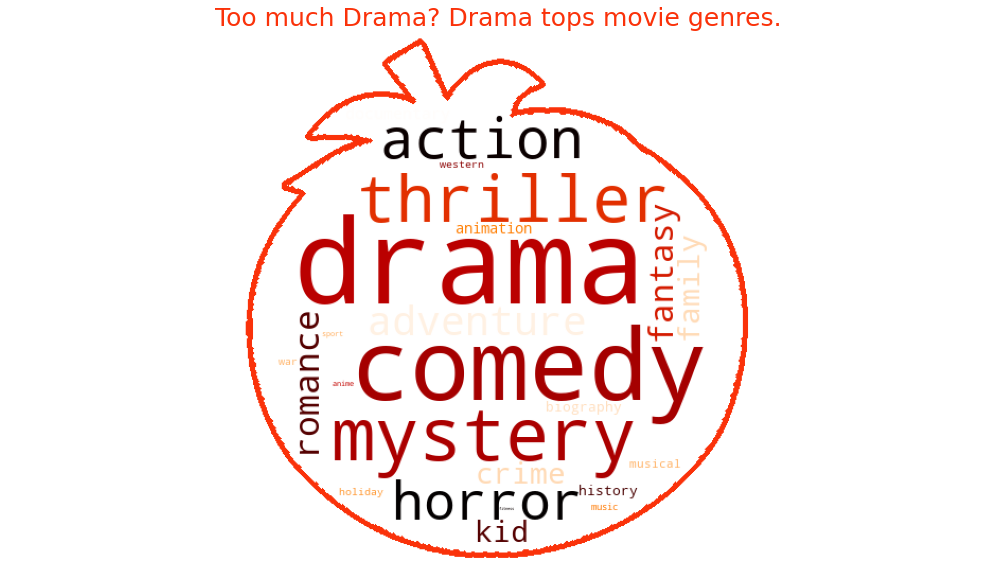

In [17]:
(create_word_cloud(df_combined['Genre'], '                          '
                   'Too much Drama? Drama tops movie genres.'
                   '                          '))

<center><span style="font-size:12px;color:#717171"><b>Figure 1. </b>Word Cloud#1: Most popular movie genres</span></center>

**INSIGHTS:**
- Drama leads the genre category and is immediately followed by comedy, mystery, and thriller. This is consistent with the statistics of movies and market shares released based on genre by the Nash Information Services LLC. [[5]](#North_American_Movie_Territory) for the North American Market. 
- On the other hand, documentary genre which is the 3rd in terms of movie count in the aforementioned statistics article was not found in our movies dataset. This limitation is because documentary movies are seldom recommended or mentioned as part of top or worst movies in the all-time movie list and countdown movie list articles (our data source) in the Rotten Tomatoes' website.

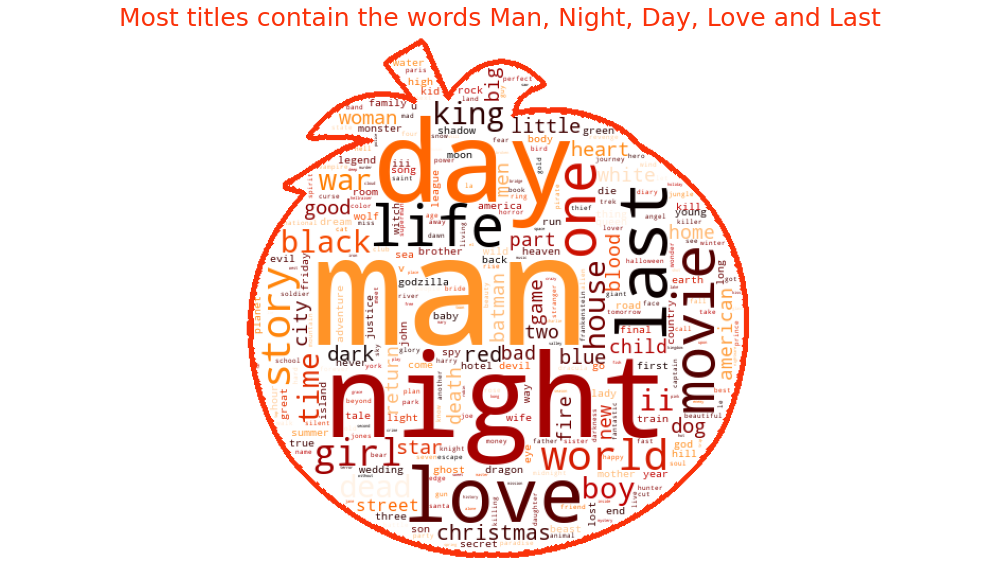

In [18]:
(create_word_cloud(df_combined['Title'],
                   '              '
                   'Most titles contain the words Man, Night, Day, Love '
                   'and Last              '))

<center><span style="font-size:12px;color:#717171"><b>Figure 2. </b>Word Cloud#2: Most popular words in movie titles</span></center>

**INSIGHTS:**
- Most popular/common words in movie titles are man, night, day, love, and last. This is consistent with the common practice of setting movie titles that are simple yet interesting that can easily be understood and could help with word-of-mouth advertising. 
- Aside from the above, the titles also frequently include some hints about what the movie is about such as life, batman, world, time, war, spy, dog, etc.

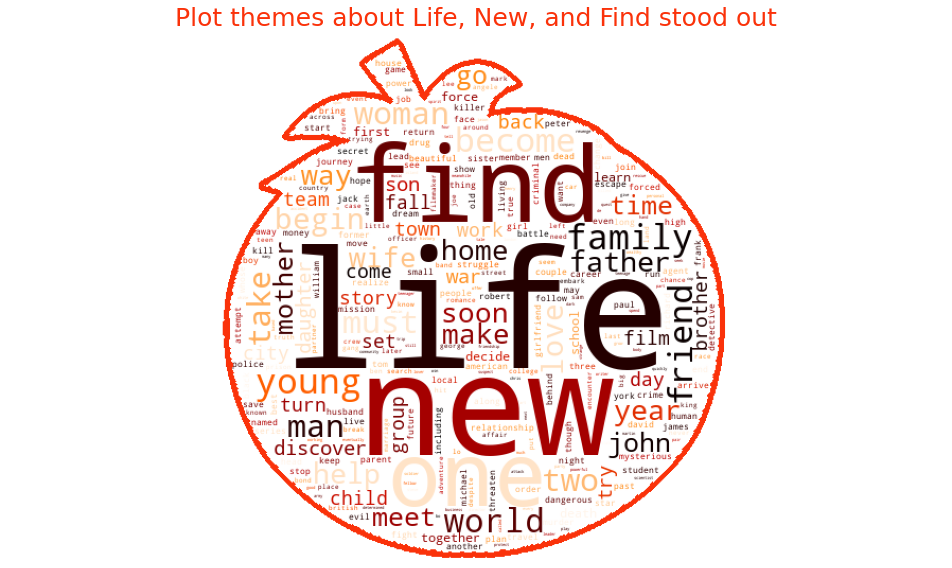

In [19]:
(create_word_cloud(df_combined['Synopsis'],
                   '                     '
                   'Plot themes about Life, New, and Find stood out'
                   '                     '))

<center><span style="font-size:12px;color:#717171"><b>Figure 3. </b>Word Cloud#3: Most popular words in plot themes</span></center>

**INSIGHTS:**
- 'Life', 'new', and 'find' words dominate most movie plots. Such words seems appropriate considering that the top genre is drama and most movie titles also mention life in general. 
- The other common words in plot themes are stil related to life: family, home, young, mother, father, etc.

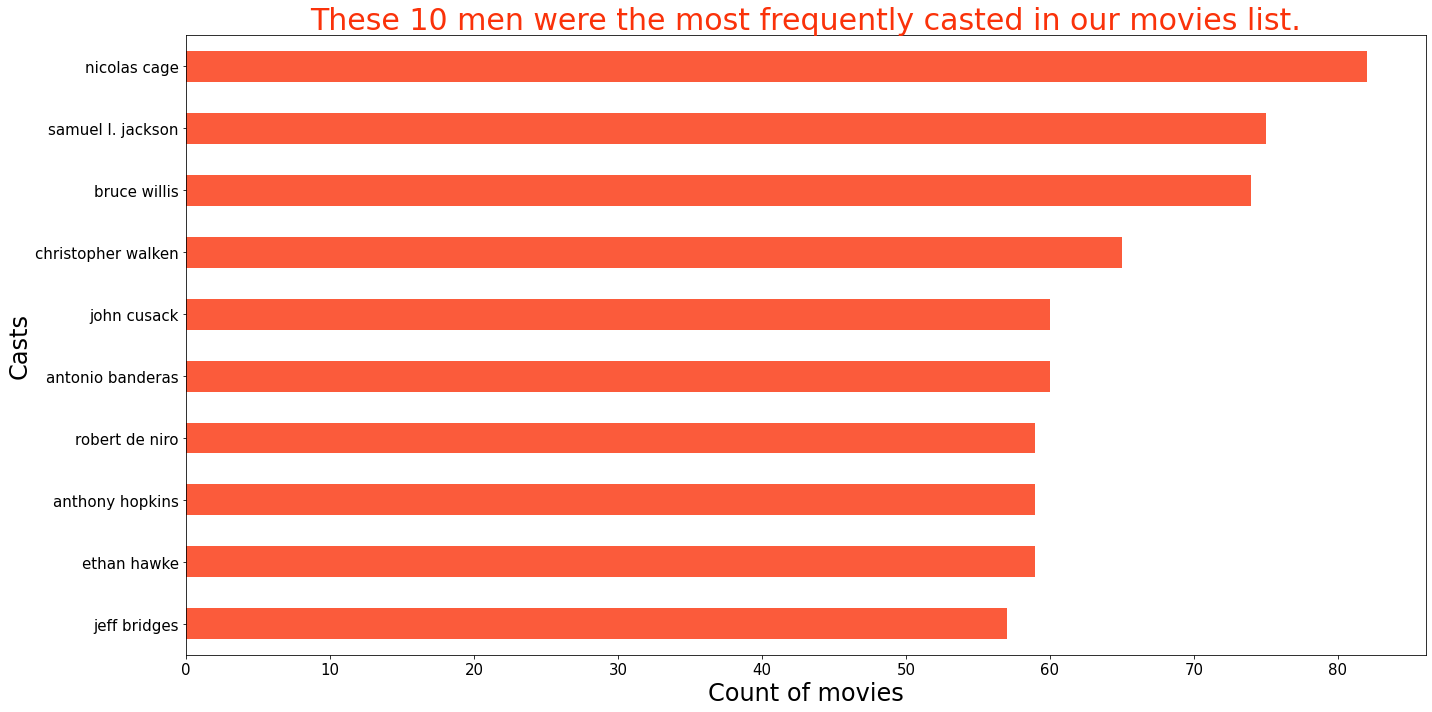

In [20]:
top_casts()

<center><span style="font-size:12px;color:#717171"><b>Figure 4. </b>Bar Graph#1: Top 10 frequently casted actors</span></center>

**INSIGHTS:**
- As highighted in the graph, the top 10 most frequently casted actors in the movies are all men and they all appeared in diverse movie genres.

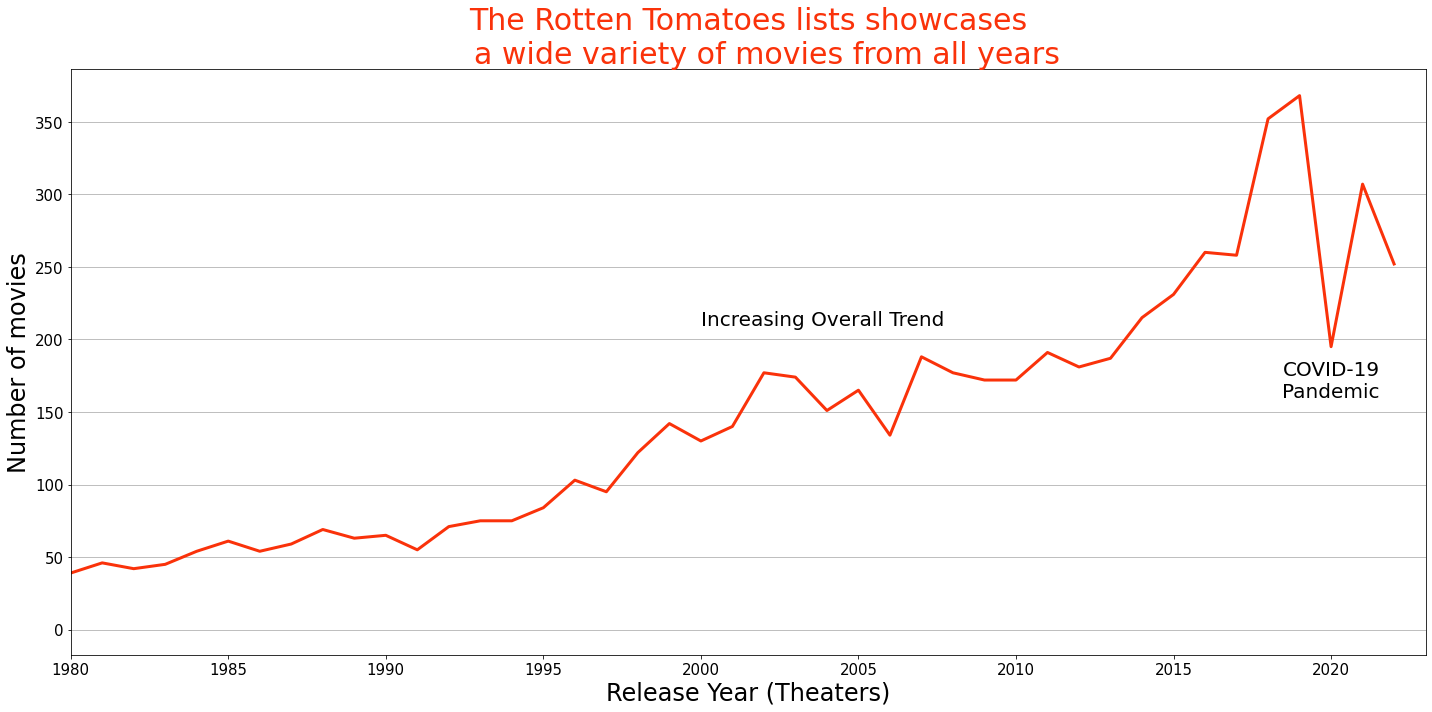

In [21]:
theater_movie_releases()

<center><span style="font-size:12px;color:#717171"><b>Figure 5. </b>Line Graph#1: Number of theater movie releases by year</span></center>

**INSIGHTS:**
- The number of movies per year from the lists we scraped follows an overall increasing trend and ends with a dip when COVID-19 pandemic happened.
- The shape formed is similar to the number of movies released in the United States and Canada from 2000 to 2021 [[6]](#US_Canada_Movie_Releases).
- This indicates that the Rotten Tomatoes lists didn't favor any particular year or period.

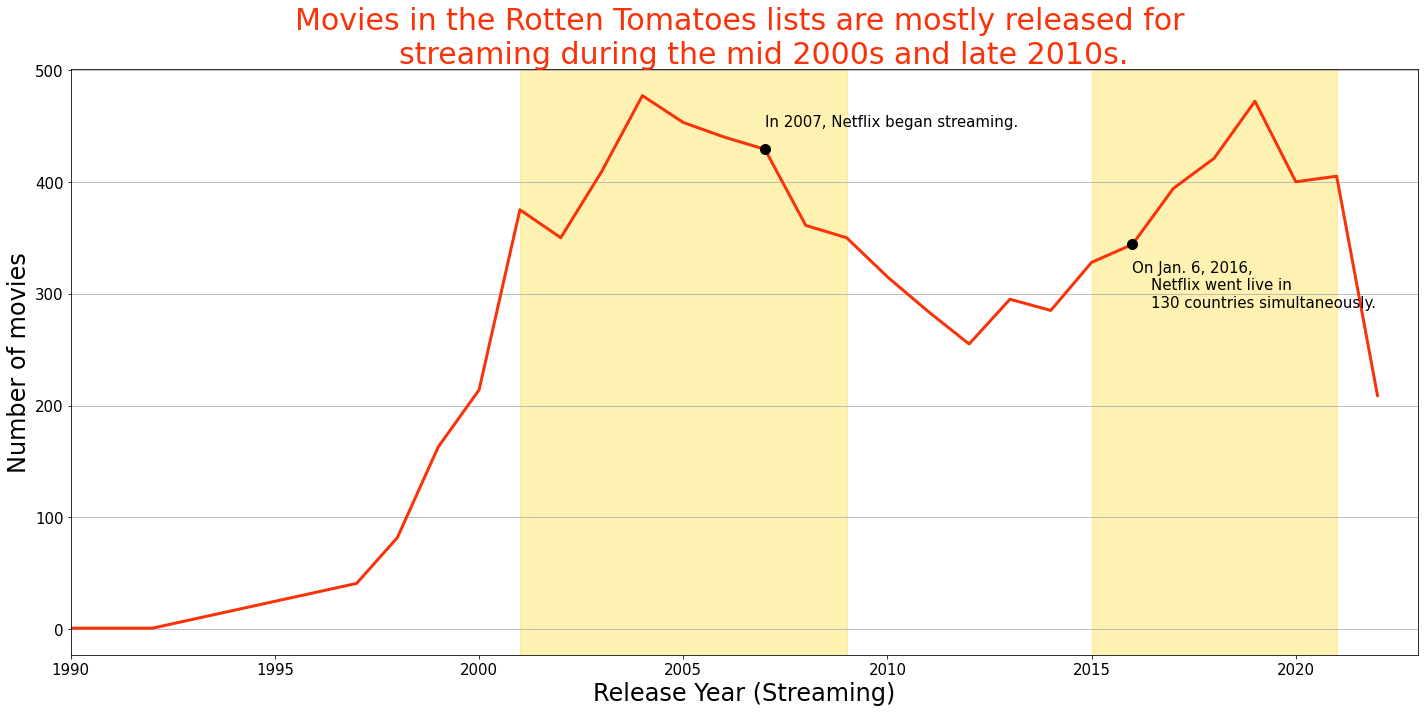

In [22]:
streaming_movie_releases()

<center><span style="font-size:12px;color:#717171"><b>Figure 6. </b>Line Graph#2: Number of streaming movie releases by year</span></center>

**INSIGHTS:**
- Plotting the streaming release of the movies scraped from the lists creates a bimodal pattern.
- The initial peak was in the mid 2000s, Netflix began streaming within that period.
- The subsequent peak was in the late 2010s, when Netflix became available worldwide.

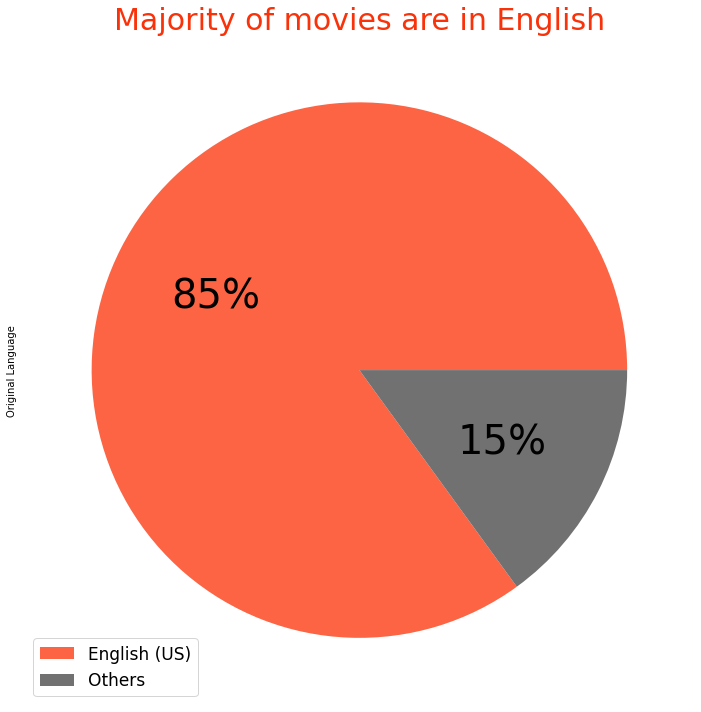

In [23]:
top_language()

<left><span style="font-size:12px;color:#717171"><b>Figure 7. </b>Pie Graph#1: % of English vs. Non-English movies</span></left>

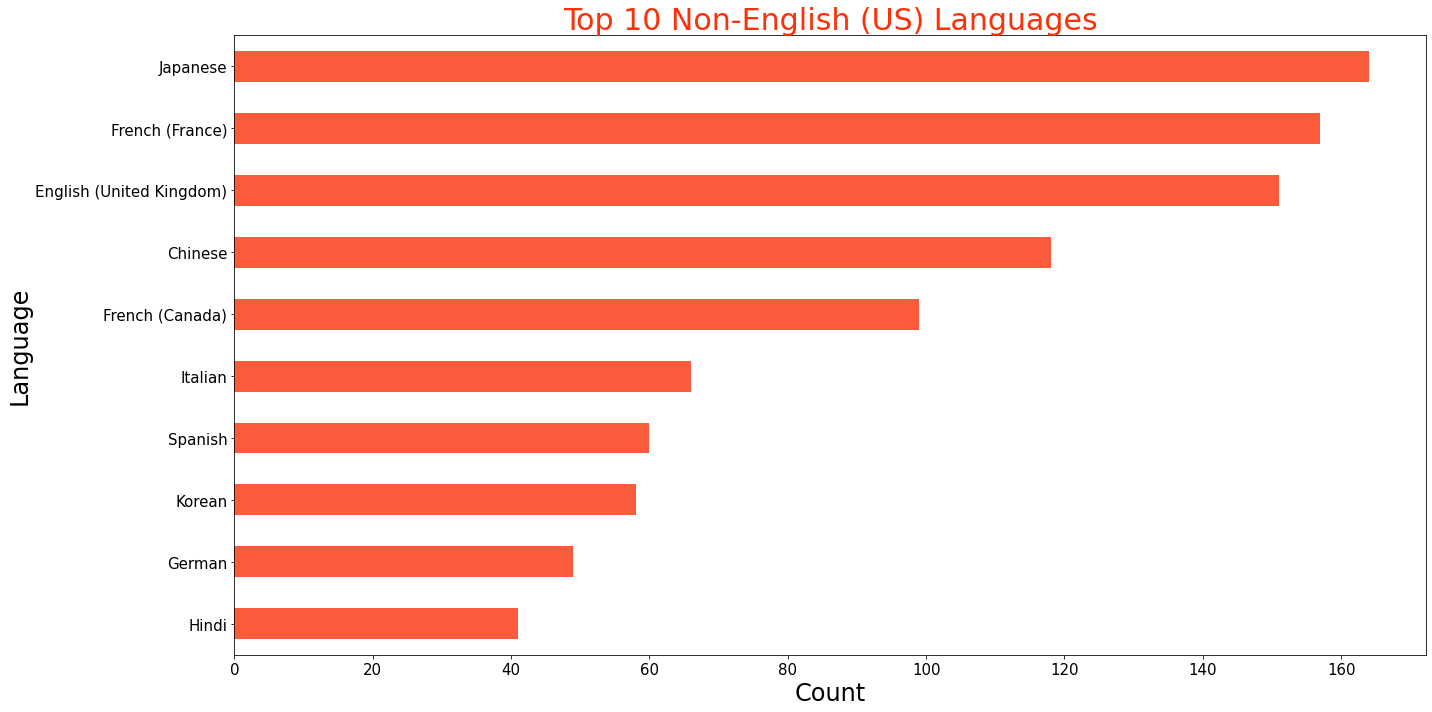

In [24]:
top_non_english()

<center><span style="font-size:12px;color:#717171"><b>Figure 8. </b>Bar Graph#2: Top 10 Non-English movie languages</span></center>

**INSIGHTS:**
- Since Rotten Tomatoes is an American review-aggregation website, it is expected that majority of the movies are in English (US).
- The succeeding languages are from the rest of the countries at the top of the film industry including French and Japanese
- Hindi is surprisingly low in the list despite India producing the most movies worldwide.

### Information Retrieval

In order to identify the most similar movies based on plots and/or casts and crew, we performed the following steps:

1. Performed **Feature extraction using Bag-Of-Words Representation** model to extract features from text and consider words or group of words as features. The intuition behind the use of this model is based on the assumption that movies are similar if they have similar content.

    We excluded the **stop words** (obtained from NLTK(Natural Language Toolkit)) to avoid irrelevant words from taking up space and processing time in our movie database and getting the top most score since these stop words commonly appear in every document.


2. Applied **Term Frequency — Inverse Document Frequency (TF-IDF)** as a scoring measure to help identify the most similar movies of a given movie title. 

    We also used **NearestNeighbor model** with **cosine similarity** as a distance metric for this study since cosine similarity is mostly used for text analyses especially when the magnitude of the vectors is not of importance. 



#### Synopsis Bag-of-Words

We used tfidfVectorizer to convert a collection of synopsis and casts and crew to a matrix of TF-IDF features. Stop words were also excluded from the bow created.

In [25]:
bow_synopsis = to_bow(
    x=df_combined,
    col_name='Synopsis',
    min_df=0.001,
    max_df=0.800,
    ngram_range=(1, 3)
)

df_synopsis = pd.DataFrame(**bow_synopsis)
print(f'Shape: {df_synopsis.shape}')
df_synopsis.head()

Shape: (8955, 7257)


,000,007,10,10 000,10 years,10-year-old,100,11,11-year-old,12,...,zach,zach galifianakis,zachary,zellweger,zeta-jones,zoe,zombie,zombies,zone,zoo
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Cast Bag-of-Words

Vectorized the first 5 listed members of the cast. Including more cast members is too much for the kernel to handle due to the dataframe blowing up in size. Refer to *Data Assumptions and Limitations* section for more information about this limitation.

In [26]:
# Save cast BOW to pickle
# df_casts_and_crew = split_to_bow(df_combined['Casts_and_crew'], 5)
# df_casts_and_crew.to_pickle("/mnt/processed/private/msds2023/lt2/Lab2/Cast_and_Crew.pkl")

In [27]:
df_casts_and_crew = pd.read_pickle(abspath_casts_and_crew)
print(f'Shape: {df_casts_and_crew.shape}')
df_casts_and_crew.head()

Shape: (8955, 18238)


,,"""hurricane ryu"" hariken",50 cent,a martinez,a. michael baldwin,a.j. langer,aamir khan,aamito lagum,aamu milonoff,aaron abrams,...,érica rivas,érik canuel,ída mekkín hlynsdóttir,ólafur darri ólafsson,óscar de la fuente,óscar jaenada,örjan gamst,øystein stene,þorsteinn bachmann,željko ivanek
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Nearest Neighbor Model

We used **NearestNeighbor model** with **cosine similarity** as a distance metric for this study since cosine similarity is mostly used for text analyses especially when the magnitude of the vectors is not of importance. 
Also, functions created are shown here for easier reference to the main model created for this study.

In [28]:
knn_plot = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine')
knn_plot.fit(df_synopsis.to_numpy())
knn_cast = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine')
knn_cast.fit(df_casts_and_crew.to_numpy())

# Functions shown here for easier reference to the main model created for this study
def get_nearest_plot(idx, n):
    """Returns the nearest movies based on plot."""
    vector = df_synopsis.loc[idx]
    return knn_plot.kneighbors([vector], n, return_distance=False)

def get_nearest_cast(idx, n):
    """Returns the nearest movies based on casts."""
    vector = df_casts_and_crew.loc[idx]
    return knn_cast.kneighbors([vector], n, return_distance=False)

titles = df_combined['Title']

def display_nearest(idx, n=5, query=False):
    """Returns the nearest movies based on movie and plot."""
    
    # If movie title was provided instead of the index number, the model
    # would get the index of the given title from our movie database. 
    if query:
        idx = titles.where(
            titles.str.contains(idx, case=False)
        ).first_valid_index()
    try:
        df_nearest_plot = df_combined.iloc[get_nearest_plot(idx, n).flatten()]
        df_nearest_plot = df_nearest_plot[['Title', 'Genre', 'Synopsis']]
    except KeyError:
        print('invalid query/index')
        return 

    nearest_id = get_nearest_cast(idx, n).flatten()
    casts = df_combined.iloc[nearest_id][['Casts_and_crew']]
    casts = casts['Casts_and_crew'].apply(lambda x: x.split(', ')[:5])
    casts = pd.DataFrame(casts.values.tolist(), index=nearest_id)
    casts.columns = [f'Cast {x+1}' for x in range(len(casts.columns))]
    title = df_combined.iloc[nearest_id][['Title', 'Genre']]
    df_nearest_cast = pd.concat([title,casts], axis=1)
    print(f'{n} most similar movies by plot:')
    display(df_nearest_plot)    
    print(f'{n} most similar movies by cast:')
    display(df_nearest_cast)

<h1 style="color:#0ec752">RESULTS AND DISCUSSIONS</h1>

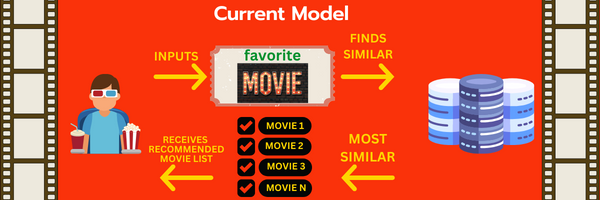

<center><span style="font-size:12px;color:#717171"><b>Figure 9. </b>Simple illustration of the Recommender Service Model</span></center>

After creating the model functions in the previous section, we can now use it to return the most similar movies based on plots and casts depending on the movie title/index that a user provided. The output that would be returned is sorted from most similar to least similar movie based on plot and cast. 

A user could also input specific word or words that a title contains. When that was executed, the model would find the index of the first movie that it finds containing such word, then use that to find the most similar movies from our database.

**Format:**

display_nearest(**idx**, **n**=5, **query**=False)

Where **idx** is the database index of the movie;

**n** is the number of movies to return (ordered by most similar to least similar), defaults to 5 items if no 'n' input was provided; and

**query** defaults to false. This should be True if a text string was input in idx instead of the actual index of the movie.

<h2 style="color:#03902e">Scenario #1: User input = idx and n (optional)</h2> 

In [29]:
display_nearest(478, 8)

8 most similar movies by plot:


,Title,Genre,Synopsis
478,Harry Potter and the Deathly Hallows: Part 1,"Fantasy, Adventure","Without the guidance and protection of their professors, Harry (Daniel Radcliffe), Ron (Rupert Grint) and Hermione (Emma Watson) begin a mission to destroy the Horcruxes, the sources of Voldemort's immortality. Though they must rely on one another more than ever, dark forces threaten to tear them apart. Voldemort's Death Eaters have seized control of the Ministry of Magic and Hogwarts, and they are searching for Harry -- even as he and his friends prepare for the ultimate showdown."
518,Harry Potter and the Deathly Hallows: Part 2,"Fantasy, Adventure","A clash between good and evil awaits as young Harry (Daniel Radcliffe), Ron (Rupert Grint) and Hermione (Emma Watson) prepare for a final battle against Lord Voldemort (Ralph Fiennes). Harry has grown into a steely lad on a mission to rid the world of evil. The friends must search for the Horcruxes that keep the dastardly wizard immortal. Harry and Voldemort meet at Hogwarts Castle for an epic showdown where the forces of darkness may finally meet their match."
481,Harry Potter and the Chamber of Secrets,"Kids & family, Fantasy, Adventure","The follow-up to ""Harry Potter and the Sorcerer's Stone"" finds young wizard Harry Potter (Daniel Radcliffe) and his friends, Ron (Rupert Grint) and Hermione (Emma Watson), facing new challenges during their second year at Hogwarts School of Witchcraft and Wizardry as they try to discover a dark force that is terrorizing the school."
498,Harry Potter and the Goblet of Fire,"Fantasy, Adventure","The fourth movie in the Harry Potter franchise sees Harry (Daniel Radcliffe) returning for his fourth year at Hogwarts School of Witchcraft and Wizardry, along with his friends, Ron (Rupert Grint) and Hermione (Emma Watson). There is an upcoming tournament between the three major schools of magic, with one participant selected from each school by the Goblet of Fire. When Harry's name is drawn, even though he is not eligible and is a fourth player, he must compete in the dangerous contest."
504,Harry Potter and the Prisoner of Azkaban,"Kids & family, Fantasy, Adventure","Harry Potter's (Daniel Radcliffe) third year at Hogwarts starts off badly when he learns deranged killer Sirius Black (Gary Oldman) has escaped from Azkaban prison and is bent on murdering the teenage wizard. While Hermione's (Emma Watson) cat torments Ron's (Rupert Grint) sickly rat, causing a rift among the trio, a swarm of nasty Dementors is sent to protect the school from Black. A mysterious new teacher helps Harry learn to defend himself, but what is his secret tie to Sirius Black?"
479,Harry Potter and the Order of the Phoenix,"Fantasy, Adventure","Now in his fifth year at Hogwarts, Harry (Daniel Radcliffe) learns that many in the wizarding community do not know the truth of his encounter with Lord Voldemort. Cornelius Fudge, minister of Magic, appoints his toady, Dolores Umbridge, as Defense Against the Dark Arts teacher, for he fears that professor Dumbledore will take his job. But her teaching is deficient and her methods, cruel, so Harry prepares a group of students to defend the school against a rising tide of evil."
492,Harry Potter and the Half-Blood Prince,"Kids & family, Fantasy, Adventure","As Death Eaters wreak havoc in both Muggle and Wizard worlds, Hogwarts is no longer a safe haven for students. Though Harry (Daniel Radcliffe) suspects there are new dangers lurking within the castle walls, Dumbledore is more intent than ever on preparing the young wizard for the final battle with Voldemort. Meanwhile, teenage hormones run rampant through Hogwarts, presenting a different sort of danger. Love may be in the air, but tragedy looms, and Hogwarts may never be the same again."
3294,What If,"Romance, Comedy","A medical-school dropout (Daniel Radcliffe) tries to hide his attraction to his new friend (Zoe Kazan), a bubbly artist who already has a boyfriend."


8 most similar movies by cast:


,Title,Genre,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5
518,Harry Potter and the Deathly Hallows: Part 2,"Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Ralph Fiennes,Alan Rickman
478,Harry Potter and the Deathly Hallows: Part 1,"Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Ralph Fiennes,Alan Rickman
498,Harry Potter and the Goblet of Fire,"Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Robbie Coltrane,Ralph Fiennes
481,Harry Potter and the Chamber of Secrets,"Kids & family, Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Kenneth Branagh,John Cleese
480,Harry Potter and the Sorcerer's Stone,"Kids & family, Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,John Cleese,Robbie Coltrane
479,Harry Potter and the Order of the Phoenix,"Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Helena Bonham Carter,Robbie Coltrane
504,Harry Potter and the Prisoner of Azkaban,"Kids & family, Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Gary Oldman,David Thewlis
492,Harry Potter and the Half-Blood Prince,"Kids & family, Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Helena Bonham Carter,Jim Broadbent


In [30]:
display_nearest(4770, 8)

8 most similar movies by plot:


,Title,Genre,Synopsis
4770,The Fast and the Furious,"Action, Adventure","Dominic Toretto (Vin Diesel) enjoys the adrenaline of street car racing and his fans treat him like a rock star. After a blazing encounter with the ruthless Johnny Tran, Dom decides to take Brian (Paul Walker), a newcomer to street racing, under his wing. Dom's sister Mia sees something she likes in Brian, too. Trouble is, neither of them realize he's an undercover cop, and Dominic and his rival Johnny Tran are both the prime suspects in a case involving dirty money and big-rig hijacking."
4769,Fast & Furious,"Action, Mystery & thriller","When a crime brings them back to the mean streets of Los Angeles, fugitive ex-convict Dom Toretto (Vin Diesel) and agent Brian O'Conner (Paul Walker) reignite their high-octane feud. However, when a common enemy rears his head, Dom and Brian must learn how to work together and trust one another in order to defeat him."
387,Fast Five,Action,"Ever since ex-cop Brian O'Conner (Paul Walker) and Mia Torretto (Jordana Brewster) broke her brother Dom (Vin Diesel) out of custody, they've traveled border to border to evade authorities. In Rio de Janeiro, they must do one final job before they can gain their freedom for good. Assembling their elite team of car racers, Brian and Dom know they must confront the corrupt businessman who wants them dead, before the federal agent (Dwayne Johnson) on their trail finds them."
1737,Fast & Furious 6,Action,"Since Dom (Vin Diesel) and Brian's (Paul Walker) heist in Rio left them and their crew very rich people, they've scattered across the globe; however, they must still live as fugitives, unable to return home to their families. Meanwhile, Agent Hobbs (Dwayne Johnson) has been tracking a gang of lethally skilled mercenary drivers whose second-in-command is someone Dom knows. Unable to take them down himself, Hobbs asks Dom and his crew for help in exchange for full pardons for everyone."
8065,F9 The Fast Saga,"Action, Adventure, Crime","Vin Diesel's Dom Toretto is leading a quiet life off the grid with Letty and his son, little Brian, but they know that danger always lurks just over their peaceful horizon. This time, that threat will force Dom to confront the sins of his past if he's going to save those he loves most. His crew joins together to stop a world-shattering plot led by the most skilled assassin and high-performance driver they've ever encountered: a man who also happens to be Dom's forsaken brother, Jakob (John Cena, the upcoming The Suicide Squad)."
1063,Furious 7,"Action, Adventure, Mystery & thriller","After defeating international terrorist Owen Shaw, Dominic Toretto (Vin Diesel), Brian O'Conner (Paul Walker) and the rest of the crew have separated to return to more normal lives. However, Deckard Shaw (Jason Statham), Owen's older brother, is thirsty for revenge. A slick government agent offers to help Dom and company take care of Shaw in exchange for their help in rescuing a kidnapped computer hacker who has developed a powerful surveillance program."
368,The Fate of the Furious,"Action, Adventure, Mystery & thriller","With Dom and Letty married, Brian and Mia retired and the rest of the crew exonerated, the globe-trotting team has found some semblance of a normal life. They soon face an unexpected challenge when a mysterious woman named Cipher forces Dom to betray them all. Now, they must unite to bring home the man who made them a family and stop Cipher from unleashing chaos."
5321,2 Fast 2 Furious,Action,"This sequel focuses on ex-police officer Brian O'Conner (Paul Walker), who relocates from Los Angeles to Miami to start over. Becoming involved in the street-racing scene in his new city, Brian befriends car-savvy Tej (Chris ""Ludacris"" Bridges) and Suki (Devon Aoki), but his competitive streak ends when federal agents apprehend him and he must enter into a deal with the FBI. Working with new partner Roman Pearce (Tyrese), Brian begins a dangerous mission to take down a

8 most similar movies by cast:


,Title,Genre,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5
4770,The Fast and the Furious,"Action, Adventure",Vin Diesel,Paul Walker,Michelle Rodriguez,Jordana Brewster,Rick Yune
4769,Fast & Furious,"Action, Mystery & thriller",Vin Diesel,Paul Walker,Michelle Rodriguez,Jordana Brewster,John Ortiz
1737,Fast & Furious 6,Action,Vin Diesel,Paul Walker,Dwayne Johnson,Michelle Rodriguez,Jordana Brewster
1063,Furious 7,"Action, Adventure, Mystery & thriller",Vin Diesel,Paul Walker,Dwayne Johnson,Michelle Rodriguez,Tyrese Gibson
387,Fast Five,Action,Vin Diesel,Paul Walker,Jordana Brewster,Tyrese Gibson,Ludacris
8065,F9 The Fast Saga,"Action, Adventure, Crime",Vin Diesel,Michelle Rodriguez,Jordana Brewster,Tyrese Gibson,Ludacris
368,The Fate of the Furious,"Action, Adventure, Mystery & thriller",Vin Diesel,Dwayne Johnson,Charlize Theron,Jason Statham,Michelle Rodriguez
5732,Guardians of the Galaxy,"Sci-fi, Adventure, Action, Fantasy, Comedy",Chris Pratt,Zoe Saldana,Dave Bautista,Vin Diesel,Bradley Cooper


In [31]:
display_nearest(1292, 9)

9 most similar movies by plot:


,Title,Genre,Synopsis
1292,Star Wars: The Force Awakens,"Sci-fi, Adventure, Action, Fantasy","Thirty years after the defeat of the Galactic Empire, the galaxy faces a new threat from the evil Kylo Ren (Adam Driver) and the First Order. When a defector named Finn crash-lands on a desert planet, he meets Rey (Daisy Ridley), a tough scavenger whose droid contains a top-secret map. Together, the young duo joins forces with Han Solo (Harrison Ford) to make sure the Resistance receives the intelligence concerning the whereabouts of Luke Skywalker (Mark Hamill), the last of the Jedi Knights."
1351,Star Wars: Episode IV -- A New Hope,"Sci-fi, Adventure, Action, Fantasy","The Imperial Forces -- under orders from cruel Darth Vader (David Prowse) -- hold Princess Leia (Carrie Fisher) hostage, in their efforts to quell the rebellion against the Galactic Empire. Luke Skywalker (Mark Hamill) and Han Solo (Harrison Ford), captain of the Millennium Falcon, work together with the companionable droid duo R2-D2 (Kenny Baker) and C-3PO (Anthony Daniels) to rescue the beautiful princess, help the Rebel Alliance, and restore freedom and justice to the Galaxy."
6960,Star Wars: Episode VI -- Return of the Jedi,"Sci-fi, Adventure, Action, Fantasy","Luke Skywalker (Mark Hamill) battles horrible Jabba the Hut and cruel Darth Vader to save his comrades in the Rebel Alliance and triumph over the Galactic Empire. Han Solo (Harrison Ford) and Princess Leia (Carrie Fisher) reaffirm their love and team with Chewbacca, Lando Calrissian (Billy Dee Williams), the Ewoks and the androids C-3PO and R2-D2 to aid in the disruption of the Dark Side and the defeat of the evil emperor."
1350,Star Wars: Episode V -- The Empire Strikes Back,"Sci-fi, Adventure, Action, Fantasy","The adventure continues in this ""Star Wars"" sequel. Luke Skywalker (Mark Hamill), Han Solo (Harrison Ford), Princess Leia (Carrie Fisher) and Chewbacca (Peter Mayhew) face attack by the Imperial forces and its AT-AT walkers on the ice planet Hoth. While Han and Leia escape in the Millennium Falcon, Luke travels to Dagobah in search of Yoda. Only with the Jedi master's help will Luke survive when the dark side of the Force beckons him into the ultimate duel with Darth Vader (David Prowse)."
6945,Star Wars: The Last Jedi,"Sci-fi, Adventure, Action, Fantasy","Luke Skywalker's peaceful and solitary existence gets upended when he encounters Rey, a young woman who shows strong signs of the Force. Her desire to learn the ways of the Jedi forces Luke to make a decision that changes their lives forever. Meanwhile, Kylo Ren and General Hux lead the First Order in an all-out assault against Leia and the Resistance for supremacy of the galaxy."
7122,Star Wars: The Rise of Skywalker,"Sci-fi, Adventure, Action, Fantasy","When it's discovered that the evil Emperor Palpatine did not die at the hands of Darth Vader, the rebels must race against the clock to find out his whereabouts. Finn and Poe lead the Resistance to put a stop to the First Order's plans to form a new Empire, while Rey anticipates her inevitable confrontation with Kylo Ren. Warning: Some flashing-lights scenes in this film may affect photosensitive viewers."
8924,Solo: A Star Wars Story,"Sci-fi, Adventure, Action, Fantasy","Young Han Solo finds adventure when he joins forces with a gang of galactic smugglers and a 190-year-old Wookie named Chewbacca. Indebted to the gangster Dryden Vos, the crew devises a daring plan to travel to the mining planet Kessel to steal a batch of valuable coaxium. In need of a fast ship, Solo meets Lando Calrissian, the suave owner of the perfect vessel for the dangerous mission -- the Millennium Falcon."
393,Rogue One: A Star Wars Story,"Sci-fi, Adventure, Action, Fantasy","Former scientist Galen Erso lives on a farm with his wife and young daughter, Jyn. His peaceful existence comes crashing down when the evil Orson Krennic takes him away from his beloved family. Many years later, Galen becomes the Empire's lead eng

9 most similar movies by cast:


,Title,Genre,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5
1292,Star Wars: The Force Awakens,"Sci-fi, Adventure, Action, Fantasy",Harrison Ford,Mark Hamill,Carrie Fisher,Adam Driver,Daisy Ridley
7122,Star Wars: The Rise of Skywalker,"Sci-fi, Adventure, Action, Fantasy",Carrie Fisher,Mark Hamill,Adam Driver,Daisy Ridley,John Boyega
6945,Star Wars: The Last Jedi,"Sci-fi, Adventure, Action, Fantasy",Mark Hamill,Carrie Fisher,Adam Driver,Daisy Ridley,John Boyega
1350,Star Wars: Episode V -- The Empire Strikes Back,"Sci-fi, Adventure, Action, Fantasy",Mark Hamill,Harrison Ford,Carrie Fisher,Billy Dee Williams,Anthony Daniels
6960,Star Wars: Episode VI -- Return of the Jedi,"Sci-fi, Adventure, Action, Fantasy",Mark Hamill,Harrison Ford,Carrie Fisher,Billy Dee Williams,Anthony Daniels
1351,Star Wars: Episode IV -- A New Hope,"Sci-fi, Adventure, Action, Fantasy",Mark Hamill,Harrison Ford,Carrie Fisher,Alec Guinness,Peter Cushing
8564,Patriot Games,"Mystery & thriller, Action",Harrison Ford,Anne Archer,Patrick Bergin,Sean Bean,Thora Birch
8563,The Mosquito Coast,"Adventure, Drama",Harrison Ford,Dame Helen Mirren,River Phoenix,Jadrien Steele,Hilary Gordon
8572,Cowboys & Aliens,"Sci-fi, Western, Action",Daniel Craig,Harrison Ford,Olivia Wilde,Sam Rockwell,Adam Beach


In [32]:
display_nearest(2474) # No n provided, defaults to 5 rows

5 most similar movies by plot:


,Title,Genre,Synopsis
2474,Christmas Carol: The Movie,"Kids & family, Holiday, Fantasy, Animation","In this animated retelling of Charles Dickens' classic tale, Ebeneezer Scrooge (Simon Callow) remains the same old curmudgeonly hermit. As he tries to resist the Christmas cheer surrounding him, several ghosts appear to him to show him the error of his ways. The Ghost of Christmas Past (Jane Horrocks), the Ghost of Christmas Present (Michael Gambon), former partner Marley (Nicolas Cage) and an earnest mouse help him change his cold heart just in time for the holiday."
5804,A Christmas Carol,"Kids & family, Holiday, Fantasy","Crotchety miser Ebenezer Scrooge (Reginald Owen) hates Christmas and mistreats his long-suffering employee, devoted family man Bob Cratchit (Gene Lockhart). But a visit from the ghost of his former business partner Jacob Marley (Leo G. Carroll) and three Christmas spirits (Lionel Braham, Ann Rutherford, D'Arcy Corrigan) might convince him to change his ways and become more kindhearted. This adaptation of the Charles Dickens classic became a holiday staple for decades."
5805,A Charlie Brown Christmas,"Animation, Comedy, Kids & family","Christmastime is here. Happiness and cheer. And for Peanuts fans everywhere, it just wouldn't be Christmas without this classic holiday delight. Christmas lights may be twinkling red and green, but Charlie Brown has the Yuletide blues. To get in the holiday spirit, he takes Lucy's advice and directs the Christmas play. And what's a Christmas play without a Christmas tree? But everyone makes fun of the short, spindly nevergreen Charlie Brown brings back - until the real meaning of Christmas works its magic once again"
5797,Mickey's Christmas Carol,"Kids & family, Holiday, Fantasy, Animation",A retelling of the classic Dickens tale with Disney's classic characters.
5822,Scrooged,"Holiday, Comedy, Fantasy","In this modern take on Charles Dickens' ""A Christmas Carol,"" Frank Cross (Bill Murray) is a wildly successful television executive whose cold ambition and curmudgeonly nature has driven away the love of his life, Claire Phillips (Karen Allen). But after firing a staff member, Eliot Loudermilk (Bobcat Goldthwait), on Christmas Eve, Frank is visited by a series of ghosts who give him a chance to re-evaluate his actions and right the wrongs of his past."


5 most similar movies by cast:


,Title,Genre,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5
2474,Christmas Carol: The Movie,"Kids & family, Holiday, Fantasy, Animation",Simon Callow,Kate Winslet,Nicolas Cage,Michael Gambon,Jane Horrocks
2431,Bad Lieutenant: Port of Call New Orleans,"Crime, Drama",Nicolas Cage,Eva Mendes,Val Kilmer,Xzibit,Fairuza Balk
151,Titanic,"History, Drama, Romance",Leonardo DiCaprio,Kate Winslet,Billy Zane,Kathy Bates,Frances Fisher
8474,"The Cook, the Thief, His Wife and Her Lover",Drama,Richard Bohringer,Michael Gambon,Dame Helen Mirren,Alan Howard,Tim Roth
6036,Mary Reilly,Drama,Julia Roberts,John Malkovich,George Cole,Michael Gambon,Kathy Staff


<h2 style="color:#03902e">Scenario #2: User input = title and query=True </h2> 

This can be used when the user don't know the exact/complete title. The model will find any movie title that contains such text/string from our movie database, get the index of the first match, and return the most similar movies based on such movie input.

In [33]:
display_nearest('Harry', 8, query=True)

8 most similar movies by plot:


,Title,Genre,Synopsis
478,Harry Potter and the Deathly Hallows: Part 1,"Fantasy, Adventure","Without the guidance and protection of their professors, Harry (Daniel Radcliffe), Ron (Rupert Grint) and Hermione (Emma Watson) begin a mission to destroy the Horcruxes, the sources of Voldemort's immortality. Though they must rely on one another more than ever, dark forces threaten to tear them apart. Voldemort's Death Eaters have seized control of the Ministry of Magic and Hogwarts, and they are searching for Harry -- even as he and his friends prepare for the ultimate showdown."
518,Harry Potter and the Deathly Hallows: Part 2,"Fantasy, Adventure","A clash between good and evil awaits as young Harry (Daniel Radcliffe), Ron (Rupert Grint) and Hermione (Emma Watson) prepare for a final battle against Lord Voldemort (Ralph Fiennes). Harry has grown into a steely lad on a mission to rid the world of evil. The friends must search for the Horcruxes that keep the dastardly wizard immortal. Harry and Voldemort meet at Hogwarts Castle for an epic showdown where the forces of darkness may finally meet their match."
481,Harry Potter and the Chamber of Secrets,"Kids & family, Fantasy, Adventure","The follow-up to ""Harry Potter and the Sorcerer's Stone"" finds young wizard Harry Potter (Daniel Radcliffe) and his friends, Ron (Rupert Grint) and Hermione (Emma Watson), facing new challenges during their second year at Hogwarts School of Witchcraft and Wizardry as they try to discover a dark force that is terrorizing the school."
498,Harry Potter and the Goblet of Fire,"Fantasy, Adventure","The fourth movie in the Harry Potter franchise sees Harry (Daniel Radcliffe) returning for his fourth year at Hogwarts School of Witchcraft and Wizardry, along with his friends, Ron (Rupert Grint) and Hermione (Emma Watson). There is an upcoming tournament between the three major schools of magic, with one participant selected from each school by the Goblet of Fire. When Harry's name is drawn, even though he is not eligible and is a fourth player, he must compete in the dangerous contest."
504,Harry Potter and the Prisoner of Azkaban,"Kids & family, Fantasy, Adventure","Harry Potter's (Daniel Radcliffe) third year at Hogwarts starts off badly when he learns deranged killer Sirius Black (Gary Oldman) has escaped from Azkaban prison and is bent on murdering the teenage wizard. While Hermione's (Emma Watson) cat torments Ron's (Rupert Grint) sickly rat, causing a rift among the trio, a swarm of nasty Dementors is sent to protect the school from Black. A mysterious new teacher helps Harry learn to defend himself, but what is his secret tie to Sirius Black?"
479,Harry Potter and the Order of the Phoenix,"Fantasy, Adventure","Now in his fifth year at Hogwarts, Harry (Daniel Radcliffe) learns that many in the wizarding community do not know the truth of his encounter with Lord Voldemort. Cornelius Fudge, minister of Magic, appoints his toady, Dolores Umbridge, as Defense Against the Dark Arts teacher, for he fears that professor Dumbledore will take his job. But her teaching is deficient and her methods, cruel, so Harry prepares a group of students to defend the school against a rising tide of evil."
492,Harry Potter and the Half-Blood Prince,"Kids & family, Fantasy, Adventure","As Death Eaters wreak havoc in both Muggle and Wizard worlds, Hogwarts is no longer a safe haven for students. Though Harry (Daniel Radcliffe) suspects there are new dangers lurking within the castle walls, Dumbledore is more intent than ever on preparing the young wizard for the final battle with Voldemort. Meanwhile, teenage hormones run rampant through Hogwarts, presenting a different sort of danger. Love may be in the air, but tragedy looms, and Hogwarts may never be the same again."
3294,What If,"Romance, Comedy","A medical-school dropout (Daniel Radcliffe) tries to hide his attraction to his new friend (Zoe Kazan), a bubbly artist who already has a boyfriend."


8 most similar movies by cast:


,Title,Genre,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5
518,Harry Potter and the Deathly Hallows: Part 2,"Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Ralph Fiennes,Alan Rickman
478,Harry Potter and the Deathly Hallows: Part 1,"Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Ralph Fiennes,Alan Rickman
498,Harry Potter and the Goblet of Fire,"Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Robbie Coltrane,Ralph Fiennes
481,Harry Potter and the Chamber of Secrets,"Kids & family, Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Kenneth Branagh,John Cleese
480,Harry Potter and the Sorcerer's Stone,"Kids & family, Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,John Cleese,Robbie Coltrane
479,Harry Potter and the Order of the Phoenix,"Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Helena Bonham Carter,Robbie Coltrane
504,Harry Potter and the Prisoner of Azkaban,"Kids & family, Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Gary Oldman,David Thewlis
492,Harry Potter and the Half-Blood Prince,"Kids & family, Fantasy, Adventure",Daniel Radcliffe,Rupert Grint,Emma Watson,Helena Bonham Carter,Jim Broadbent


In [34]:
display_nearest('Holmes', query=True)

5 most similar movies by plot:


,Title,Genre,Synopsis
5946,Enola Holmes 2,"Mystery & thriller, Drama, Action, Adventure, Crime","Fresh off the triumph of solving her first case, Enola Holmes (Millie Bobby Brown) follows in the footsteps of her famous brother, Sherlock (Henry Cavill), and opens her own agency -- only to find that life as a female detective-for-hire isn't as easy as it seems. Resigned to accepting the cold realities of adulthood, she is about to close shop when a penniless matchstick girl offers Enola her first official job: to find her missing sister. But this case proves to be far more puzzling than expected, as Enola is thrown into a dangerous new world -- from London's sinister factories and colorful music halls, to the highest echelons of society and 221B Baker Street itself. As the sparks of a deadly conspiracy ignite, Enola must call upon the help of friends -- and Sherlock himself -- to unravel her mystery. The game, it seems, has found its feet again!"
1945,Sherlock Gnomes,"Kids & family, Comedy, Adventure, Mystery & thriller, Animation","When Gnomeo and Juliet first arrive in London with their friends and family, their biggest concern is getting a new garden ready for spring. When everyone in the garden suddenly goes missing -- there's only one gnome to call -- Sherlock Gnomes. The famous detective and sworn protector of the city shows up with his sidekick Watson to investigate the case. The mystery soon leads the gnomes on a rollicking adventure as they meet all-new ornaments and explore an undiscovered side of London."
5972,The Private Life of Sherlock Holmes,"Adventure, Comedy, Crime, Drama, Lgbtq+","A bored Sherlock Holmes (Robert Stephens) meets Madame Petrova (Tamara Toumanova), a famed ballerina, who tries to seduce him, hoping that their child will have her body and his brains. He manages to extract himself from her grasp, using Dr. Watson (Colin Blakely) as a decoy. Then he and the doctor head for Loch Ness in search of the missing husband of Gabrielle Valladon (Genevieve Page). While there, they meet Sherlock's brother, Mycroft (Christopher Lee), who aids them in solving the mystery."
5962,Enola Holmes,"Mystery & thriller, Action, Adventure, Crime","While searching for her missing mother, intrepid teen Enola Holmes uses her sleuthing skills to outsmart big brother Sherlock and help a runaway lord."
5973,The Adventure of Sherlock Holmes' Smarter Brother,Comedy,"Sigerson Holmes (Gene Wilder) has something to prove as the lesser-known brother of famed detective Sherlock Holmes. When Sherlock and his assistant, Dr. Watson, are dispatched to Europe on assignment, Sigerson takes the opportunity to prove his mettle as a sleuth. With the aide of bug-eyed Orville Sacker (Marty Feldman) and aspiring opera singer Jenny Hill (Madeline Kahn), Sigerson attempts to crack the case of missing government documents presumed stolen by professor Moriarty (Leo McKern)."


5 most similar movies by cast:


,Title,Genre,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5
5946,Enola Holmes 2,"Mystery & thriller, Drama, Action, Adventure, Crime",Millie Bobby Brown,Henry Cavill,Helena Bonham Carter,David Thewlis,Louis Partridge
5962,Enola Holmes,"Mystery & thriller, Action, Adventure, Crime",Millie Bobby Brown,Sam Claflin,Henry Cavill,Helena Bonham Carter,Fiona Shaw
463,Big Fish,Drama,Ewan McGregor,Albert Finney,Billy Crudup,Jessica Lange,Helena Bonham Carter
6126,Zack Snyder's Justice League,"Action, Adventure, Fantasy",Ben Affleck,Gal Gadot,Henry Cavill,Jason Momoa,Ezra Miller
1102,Mission: Impossible -- Fallout,"Action, Adventure, Mystery & thriller",Tom Cruise,Henry Cavill,Ving Rhames,Simon Pegg,Rebecca Ferguson


As exhibited in the above scenarios, the model was able to return the most similar movies based on their input movie title/index from our movie database.

<h1 style="color:#0ec752">RECOMMENDATIONS (for further studies and analyses)</h1>

**1. Include more movies (via API)**

You can never go wrong with more datapoints. Fandango [[7]](#Rotten_Tomatoes_API) (Rotten Tomatoes' holding company) has an API however, it is only offered to partners and is not available to the public. Securing access to their API would guarantee that our database is exhaustive and will make the scraping process simpler and more efficient. Additional sources should also be considered to collect all the movies available publicly and to create a system that could scrape / collect those movie info in real-time.

**2 Increase the number of cast members used**

Since we only included the first 5 cast members due to memory constraints, most supporting cast members were not represented in the dataset. This restriction will cause the model to leave out potential matches that would have been caught with a complete cast list in the dataset. Using a more powerful device that can handle memory-intensive objects would get the job done.

**3. Use more detailed synopses**

A more detailed synopsis for each item would improve the model. Erroneous matches are usually from plots that are only a sentence long. Some entries only provide a brief description of the movie possibly to avoid giving away spoilers, meanwhile others discuss key plot points and even include names of actors. Obtaining plots from supplementary sources such as IMDB or Wikipedia would enhance the bag of words data and consequently improve relevance of synopsis-based recommendations.

**4. Expand search categories**

Aside from searching using the movie title / movie index, expand the search categories to allow searching by genre, casts, year, place, and others.

**5. Turn this into a business** 

After building up the database by getting real-time collection of all movies from different sources, we could create a website that could offer this movie recommendation service and earn from ad placements. Eventually, we should turn this **item-based filtering** type of recommendation model into **user-based collaborative filtering**. We could allow user account creation so the model could also learn based on the historical searches of the users as well as other users who liked the same movies. Also, the returned movie lists should include more movie info and links for better user experience.

**6. Expand to include TV series, movie and tv series reviews, blogs, songs, among others**

Once the business was proven successful, we could consider expanding the website offerings to include TV series, movie and tv series reviews, write blogs, songs, and other initiatives that could help increase website traffic and user base. 

<h1 style="color:#0ec752">CONCLUSION</h1>

Our primary aim in conducting this study was to build a recommender model, together with a large database of movie info, that can suggest movies that are most similar to a user's favorite movie (based on the user's input) in terms of movie plot and casts. 

Considering the ease of access and abundance of movie choices available for immediate consumption of each user, we want to add value to the users by providing them with a movie recommender service that could immediately provide the most similar movies from a movie that they input in our model. This reduces the time that a user spends on browsing through several movies instead of immediately watching a movie that is most similar to their taste. 

In terms of the existing movie database collected from this study, we noted that drama, comedy, mystery, and thriller led the movie genre category. The database lacks documentary genre yet, so this should be addressed by future works to increase user choices and improve user satisfaction. In line with the most popular genres, the most common words in title pertain to man, night, day, love, and last which are consistent with the common practice of setting movie titles that are simple, easy to understand, provides some context or characters about the plot, and interesting. Likewise, top plot themes pertain to life, new, and find. Lastly, the most popular casts or mostly casted actors are all men and unlike the other categories, such actors have been into diverse types of movies, instead of just drama.

One challenge that we have faced in this study was that even if we know that including and combining more features from the movie info scraped could provide higher relevance in terms of getting the most similar movie, due to memory constraints and incomplete data obtained for those features, we decided to drop those ideas and leave it for future work.

Despite the aforementioned limitation, the Bag-of-words and TF-IDF using NearestNeighbor model with cosine similarity distance metric have been extremely instrumental in building our model which provided accurate results when tested.

**This study is highly relevant, timely, and has potential business value** since recommender systems that enhance user experience and provide the most personalized and value-adding results could mean more loyal site visits and engagement from user. Consequently, higher engagement means higher potential advertising and other revenues.

<h1 style="color:#0ec752">REFERENCES</h1>

<a name='About_Rotten_Tomatoes'></a>[1]  About Rotten Tomatoes. (2022, November). Rotten Tomatoes Website https://www.rottentomatoes.com/about

<a name='All-Time_Movie_Lists'></a>[2]  All-Time Movie & TV Lists. (2022, November). Rotten Tomatoes Website https://editorial.rottentomatoes.com/all-time-lists

<a name='Countdowns_Movie_Lists'></a>[3]  Countdowns. (2022, November). Rotten Tomatoes Website https://editorial.rottentomatoes.com/countdown

<a name='Netflix_Tudum'></a>[4]  Bitran, T. (2022, November 2). Skip Intro: Netflix Turns 25 Today. Netflix Tudum. https://www.netflix.com/tudum/articles/netflix-trivia-25th-anniversary

<a name='North_American_Movie_Territory'></a>[5]  Nash Information Services, LLC. (n.d.). Market Share for Each Genre 1995-2022. Nash Information Services, LLC. https://www.the-numbers.com/market/genres

<a name='US_Canada_Movie_Releases'></a>[6]  Navarro, J. (2022, March 10). U.S. & Canada: movie releases per year 2021. Statista. https://www.statista.com/statistics/187122/movie-releases-in-north-america-since-2001/

<a name='Rotten_Tomatoes_API'></a>[7]  Rotten Tomatoes API Platform. (2022, November). Rotten Tomatoes Developer Network https://developer.fandango.com/rotten_tomatoes

**END**